(chap8)=

# 8. Approximate Bayesian Computation

In this chapter we discuss Approximate Bayesian Computation (ABC). The
"approximate" in ABC refers to the lack of explicit likelihood, but not
to the use of numerical methods to approximate the posterior, such as
Markov chain Monte Carlo or Variational Inference. Another common, and
more explicit name, for ABC methods is likelihood-free methods, although
some authors mark a difference between these terms others use them
interchangeably.

ABC methods may be useful when we do not have an explicit expression for
the likelihood, but we have a parameterized *simulator* capable of
generating synthetic data. The simulator has one or more unknown
parameters and we want to know which set of parameters generates
synthetic data *close enough* to the observed data. To this extent we
will compute a posterior distribution of those parameters.

ABC methods are becoming increasingly common in the biological sciences,
in particular in sub-fields like systems biology, epidemiology, ecology
and population genetics {cite:p}`Sunnaker2013`. But they are also used in other
domains as they provide a flexible way to solve many practical problems.
This diversity is also reflected in the Python packages available for
ABC {cite:p}`Dutta2017, Lintusaari2018, Klinger2018`. Nevertheless, the extra
layer of approximation comes with its own set of difficulties. Mainly
defining what *close enough* means in the absence of a likelihood and
then being able to actually compute an approximated posterior.

We will discuss these challenges in this chapter from a general
perspective. We highly recommend readers interested into applying ABC
methods to their own problems to complement this chapter with examples
from their own domain knowledge.

(life-beyond-likelihood)=

## 8.1. Life Beyond Likelihood

From Bayes theorem (Equation
[eq:posterior_dist](eq:posterior_dist)), to compute a posterior we
need two basic ingredients, a prior and a likelihood. However, for
particular problems, we may find that we can not express the likelihood
in closed-form, or it is prohibitively costly to compute it. This seems
to be a dead end for our Bayesian enthusiasm. But that is not
necessarily the case as long as we are able to somehow generate
synthetic data. This generator of synthetic data is generally referred
to as a *simulator*. From the perspective of the ABC method the
simulator is a black-box, we feed parameter values at one side and get
simulated data from the other. The complication we add however, is
uncertainty about which inputs are good enough to generate synthetic
data similar to the observed data.

The basic notion common to all ABC methods is to replace the likelihood
by a $\delta$ function that computes a distance or more generally some
form of discrepancy between the observed data $Y$ and the synthetic data
$\hat Y$ generated by a parameterized simulator $Sim$.

```{math}
:label: eq:simulator
\hat Y \sim Sim(\theta)
```

```{math}
:label: eq:approx_likelihood
p(\theta \mid Y) 
    \underset{\sim}{\propto} 
    \delta(Y, \hat Y \mid \epsilon)\; p(\boldsymbol{\theta})
```

We aim at using a function $\delta$ to obtain a *practically good
enough* approximation to the *true* likelihood:

```{math}
:label: eq:converge_true_likelihood
\lim_{\epsilon \to 0} \delta(Y, \hat Y \mid \epsilon) = p(Y \mid \boldsymbol{\theta})
```

We introduce a tolerance parameter $\epsilon$ because the chance of
generating a synthetic data-set $\hat Y$ being equal to the observed
data $Y$ is virtually null for most problems [^1]. The larger the value
of $\epsilon$ the more tolerant we are about how close $Y$ and $\hat Y$
has to be in order to consider them as *close enough*. In general and
for a given problem, a larger value of $\epsilon$ implies a more crude
approximation to the posterior, we will see examples of this later.

In practice, as we increase the sample size (or dimensionality) of the
data it becomes harder and harder to find a small enough values for the
distance function $\delta$ [^2]. A naive solution is to increase the
value of $\epsilon$, but this means increasing the error of our
approximation. A better solution could be to instead use one or more
summary statistics $S$ and compute the distance between the data
summaries instead of between the simulated and real datasets.

```{math}
:label: eq:summary_statistics
\delta\left(S(Y), S(\hat Y) \mid \epsilon\right)
```

We must be aware that using a summary statistic introduces an additional
source of error to the ABC approximation, unless the summary statistics
are sufficient with respect to the model parameters $\theta$.
Unfortunately, this is not always possible. Nevertheless non-sufficient
summary statistics can still be very useful in practice and they are
often used by practitioners.

In this chapter we will explore a few different distances and summary
statistics focusing on some proven methods. But know that ABC handles so
many different types of simulated data, in so many distinct fields, that
it may be hard to generalize. Moreover the literature is advancing very
quickly so we will focus on building the necessary knowledge, skills and
tools, so you find it easier to generalize to new problems as the ABC
methods continues to evolve.

::: {admonition} Sufficient statistics

A statistic is sufficient with respect to a model
parameter if no other statistic computed from the same sample provides
any additional information about that sample. In other words, that
statistics is *sufficient* to summarize your samples without losing
information. For example, given a sample of independent values from a
normal distribution with expected value $\mu$ and known finite variance
the sample mean is a **sufficient statistic** for $\mu$. Notice that the
mean says nothing about the dispersion, thus it is only sufficient with
respect to the parameter $\mu$. It is known that for iid data the only
distributions with a sufficient statistic with dimension equal to the
dimension of $\theta$ are the distributions from the Exponential family
{cite:p}`Darmois1935, Koopman1936, Pitman1936, Andersen1970`. For other
distribution, the dimension of the sufficient statistic increases with
the sample size.
:::

[^1]: It can work for discrete variables, especially if they take only a
    few possible values.

[^2]: This is another manifestation of the curse of dimensionality. See
    Section {ref}`high_dimensions` for a full explanation.

(approximating-the-approximated-posterior)=

## 8.2. Approximating the Approximated Posterior

The most basic method to perform Approximate Bayesian Computation is
probably rejection sampling. We will describe it using
{numref}`fig:abc_rejection` together with the high level step by step
description of the algorithm as follows.

1.  Sample a value of $\theta$ from the prior distribution.

2.  Pass that value to the simulator and generate synthetic data.

3.  If the synthetic data is at a *distance* $\delta$ closer than
    $\epsilon$ save the proposed $\theta$, otherwise reject it.

4.  Repeat until having the desired number of samples.

```{figure} figures/ABC_rejection.png
:name: fig:abc_rejection
:width: 4.5in
One step of an ABC-rejection sampler. We sample a set of $\theta$ values
from the prior distribution (at the top). Each value is passed to the
simulator, which generates synthetic datasets (dashed distributions), we
compare the synthetic data with the observed one (the distribution at
the bottom). In this example only $\theta_1$ was able to generate a
synthetic dataset close enough to the observed data, thus $\theta_0$ and
$\theta_2$ were rejected. Notice that if we were using a summary
statistics, instead of the entire dataset we should compute the summary
statistics of the synthetic and observed data after step 2 and before
step 3.
```

The major drawback of the ABC-rejection sampler is that if the prior
distribution is too different from the posterior distribution we will
spend most of the time proposing values that will be rejected. A better
idea is to propose from a distribution closer to the actual posterior.
Generally we do not know enough about the posterior to do this by hand,
but we can achieve it using a Sequential Monte Carlo (SMC) method. This
is a general sampler method, like the MCMC methods we have been using in
the book. SMC can be adapted to perform ABC and then it is called
SMC-ABC. If you want to learn more about the detail of the SMC method
you can read Section {ref}`inference_methods`, but to
understand this chapter you just need to know that SMC proceeds by
increasing the value of a auxiliary parameter $\beta$ in $s$ successive
stages $\{\beta_0=0 < \beta_1  < ...  < \beta_s=1\}$. This is done in
such a way that we start sampling from the prior ($\beta = 0$) until we
reach the posterior ($\beta = 1$). Thus, we can think of $\beta$ as a
parameter that *gradually turns the likelihood on*. The intermediate
values of $\beta$ are automatically computed by SMC. The more
informative the data with respect to the prior and/or the more complex
the geometry of the posterior the more intermediate steps SMC will take.
{numref}`fig:smc_tempering` shows an hypothetical sequence of
intermediate distributions from the prior in light grey to the posterior
in blue.

```{figure} figures/smc_tempering.png
:name: fig:smc_tempering
:width: 8.00in
Hypothetical sequence of tempered posteriors explored by an SMC sampler,
from the prior ($\beta = 0$), light gray, to the actual posterior
($\beta = 1$), blue. Low $\beta$ values at the beginning helps the
sampler to not get stuck in a single maximum.
```

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats

from scripts.rf_selector import select_model

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(1346)

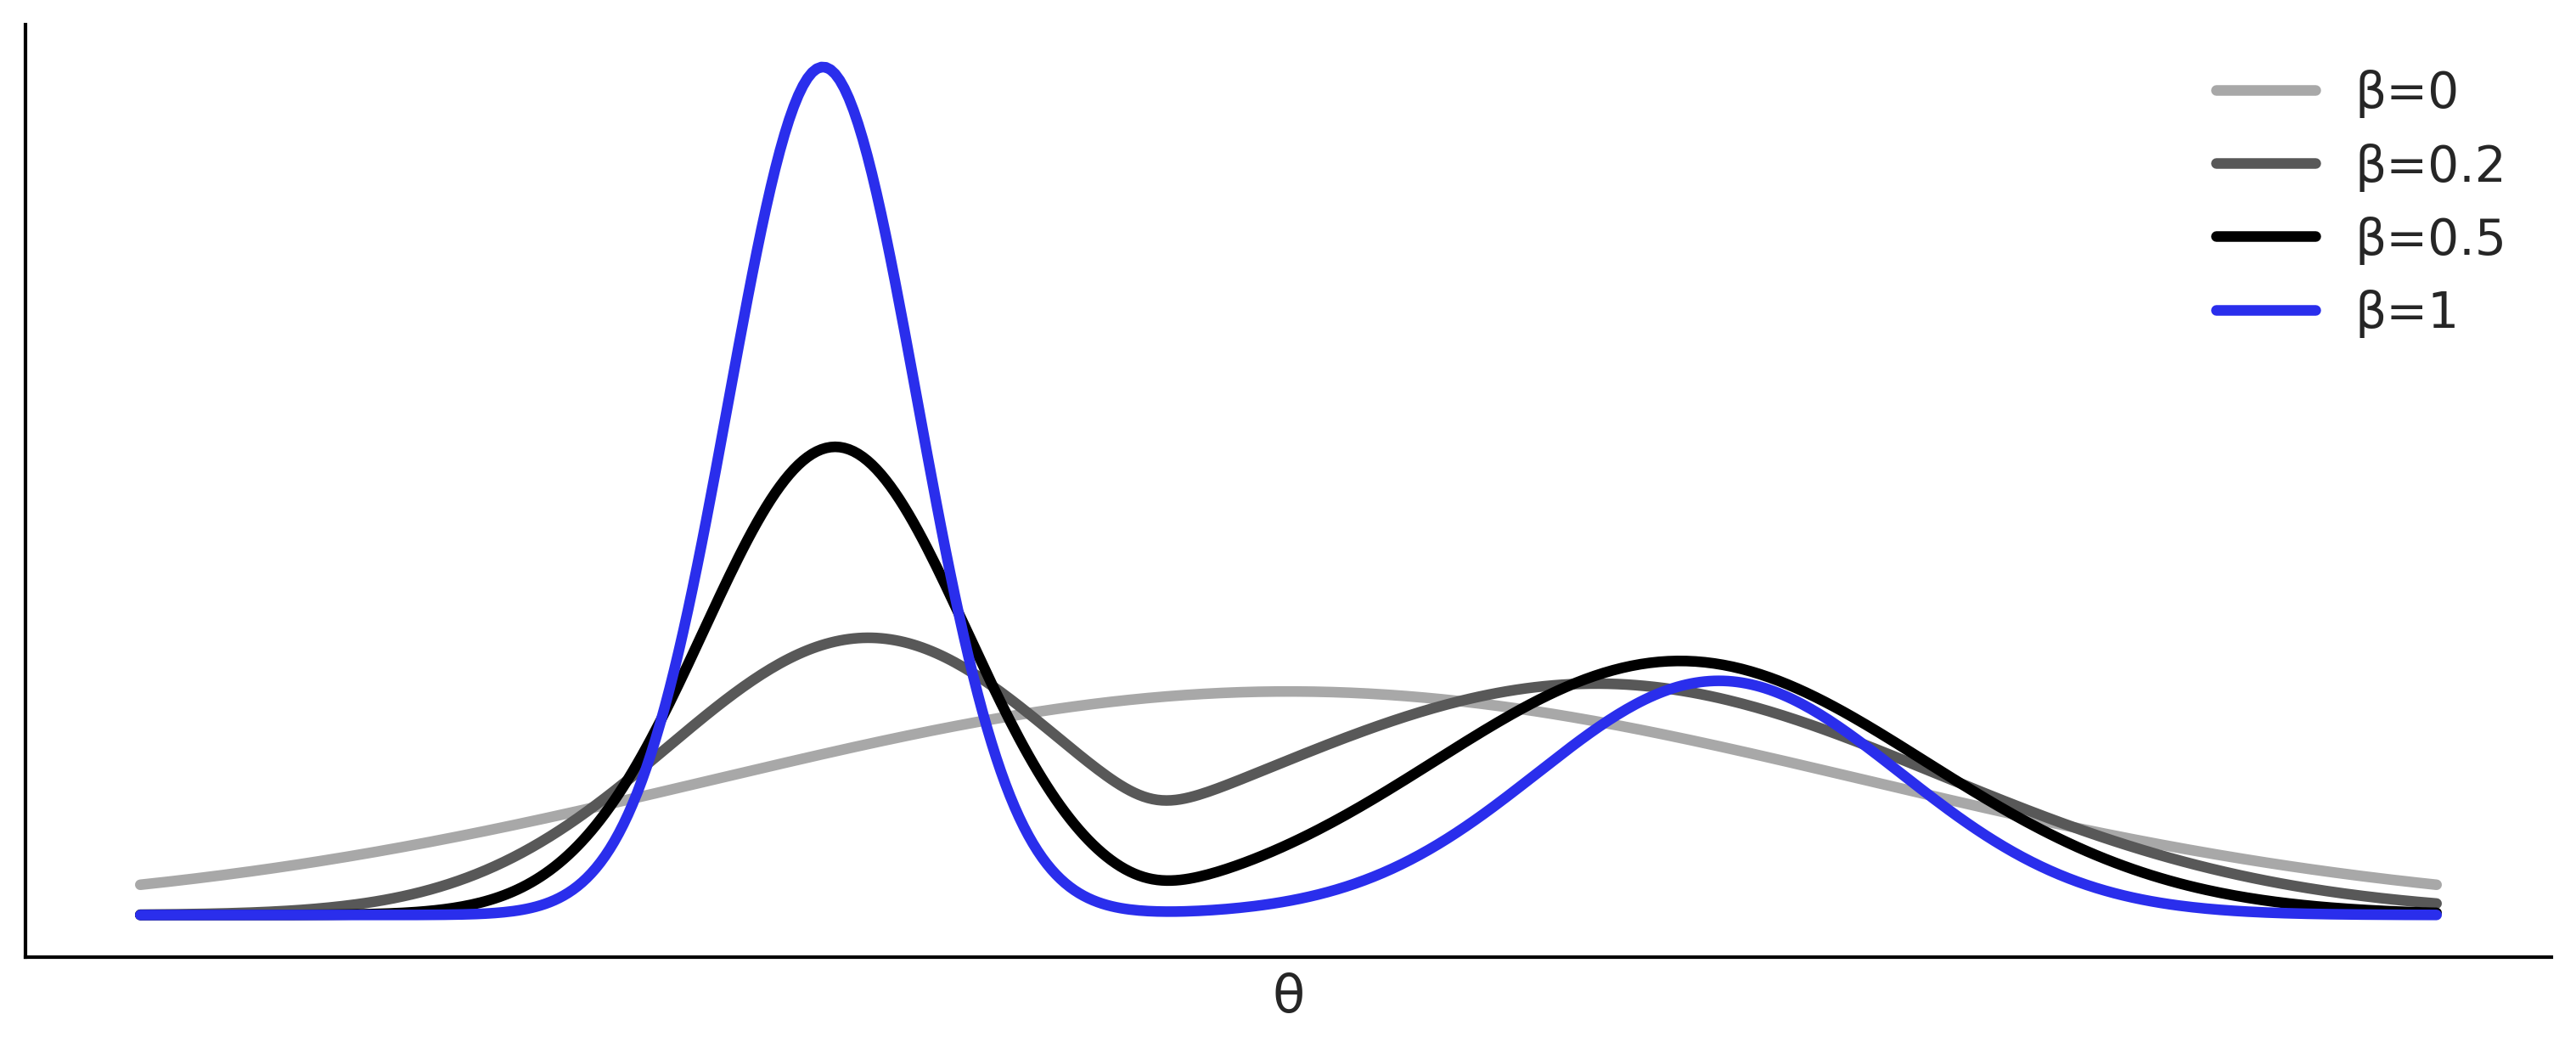

In [3]:
a = stats.norm(-2.5, 0.5)
b = stats.norm(2.5, 1)
c = stats.norm(0, 3)
x = np.linspace(-6, 6, 500)

lpdf = 0.65 * a.pdf(x) + 0.35* b.pdf(x)
ppdf = c.pdf(x)
_, ax = plt.subplots(figsize=(10, 4))
for c, β in zip(["#A8A8A8", "#585858", "#000000", "#2a2eec"],
                [0, 0.2, 0.5, 1]):
    post = ppdf * lpdf**β
    post /= post.sum()
    ax.plot(x, post, lw=3, label=f"β={β}", color=c)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("θ")
ax.legend()
plt.savefig("img/chp08/smc_tempering.png")

(fitting-a-gaussian-the-abc-way)=

## 8.3. Fitting a Gaussian the ABC-way

Let us warm up with a simple example, the estimation of the mean and
standard deviation from Gaussian distributed data with mean 0 and
standard deviation 1. For this problem we can fit the model:

```{math} 
:label: eq:Gauss_model
\begin{split}
    \boldsymbol{\mu} \sim &\; \mathcal{N}(0, 1) \\
    \boldsymbol{\sigma} \sim &\; \mathcal{HN}(1) \\
    \boldsymbol{s} \sim &\; \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma})

\end{split}
```

The straightforward way to write this model in PyMC3 is shown in Code
Block [gauss_nuts](gauss_nuts).

```{code-block} python
:name: gauss_nuts
:caption: gauss_nuts

with pm.Model() as gauss:
    μ = pm.Normal("μ", mu=0, sigma=1)
    σ = pm.HalfNormal("σ", sigma=1)
    s = pm.Normal("s", μ, σ, observed=data)
    trace_g = pm.sample()
```

The equivalent model using SMC-ABC is shown in Code Block
[gauss_abc](gauss_abc).

```{code-block} python
:name: gauss_abc
:caption: gauss_abc

with pm.Model() as gauss:
    μ = pm.Normal("μ", mu=0, sigma=1)
    σ = pm.HalfNormal("σ", sigma=1)
    s = pm.Simulator("s", normal_simulator, params=[μ, σ],
                     distance="gaussian",
                     sum_stat="sort",  
                     epsilon=1,
                     observed=data)
    trace_g = pm.sample_smc(kernel="ABC")
```

We can see there are two important differences between Code Block
[gauss_nuts](gauss_nuts) and Code Block
[gauss_abc](gauss_abc):

-   The use of the `pm.Simulator` *distribution*

-   The use of `pm.sample_smc(kernel="ABC")` instead of `pm.sample()`.

By using `pm.Simulator` we are telling PyMC3 that we are not going to
use a closed form expression for the likelihood, and instead we are
going to define a pseudo-likelihood. We need to pass a Python function
that generates synthetic data, in this example the function
`normal_simulator`, together with its parameters. Code Block
[normal_simulator](normal_simulator) shows the definition
of this function for a sample size of 1000 and unknown parameters $\mu$
and $\sigma$.

```{code-block} python
:name: normal_simulator
:caption: normal_simulator

def normal_simulator(μ, σ):
    return np.random.normal(μ, σ, 1000)
```

We may also need to pass other, optional, arguments to `pm.Simulator`
including the distance function `distance`, the summary statistics
`sum_stat` and the value of the tolerance parameter $\epsilon$
`epsilon`. We will discuss these arguments in detail later. We also pass
the observed data to the simulator distribution as with a regular
likelihood.

By using `pm.sample_smc(kernel="ABC")`[^3] we are telling PyMC3 to look
for a `pm.Simulator` in the model and use it to define a
pseudo-likelihood, the rest of the sampling process is the same as the
one described for the SMC algorithm. Other samplers will fail to run
when `pm.Simulator` is present.

The final ingredient is the `normal_simulator` function. In principle we
can use whatever Python function we want, in fact we can even wrap
non-Python code, like Fortran or C code. That is where the flexibility
of ABC methods reside. In this example our simulator is just a wrapper
around a NumPy random generator function.

As with other samplers it is recommended that we run more than one chain
so we can diagnose if the sampler failed to work properly, PyMC3 will
try to do this automatically. {numref}`fig:trace_g` shows the result of
running Code Block [gauss_abc](gauss_abc) with two chains.
We can see that we were able to recover the true parameters and that the
sampler is not showing any evident sampling issue.

```{figure} figures/trace_g.png
:name: fig:trace_g
:width: 8.00in
As expected $\mu \approx 0$ and $\sigma \approx 1$, both chains agree
about the posterior as reflected by the KDEs and also by the rank plots.
Notice that each of these 2 chains was obtained by running 2000 parallel
SMC-chains/particles as described in the SMC algorithm.

[^3]: The default SMC `kernel` is `"metropolis"`. See {ref}`inference_methods` for details.

```python
data = np.random.normal(loc=0, scale=1, size=1000)

def normal_sim(rng, a, b, size=1000):
    return rng.normal(a, b, size=size)
```

In [5]:
with pm.Model() as gauss:
    μ = pm.Normal('μ', mu=0, sigma=1)
    σ = pm.HalfNormal('σ', sigma=1)
    s = pm.Simulator('s', normal_sim, params=[μ, σ],
                     distance="gaussian",
                     sum_stat="sort",          
                     epsilon=1,
                     observed=data)
    trace_g = pm.sample_smc(chains=4)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [6]:
az.summary(trace_g)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ -0.062  0.044  -0.142    0.024      0.001      0.0    6983.0    5913.0   
σ  0.997  0.039   0.929    1.075      0.000      0.0    7313.0    6917.0   

   r_hat  
μ    1.0  
σ    1.0

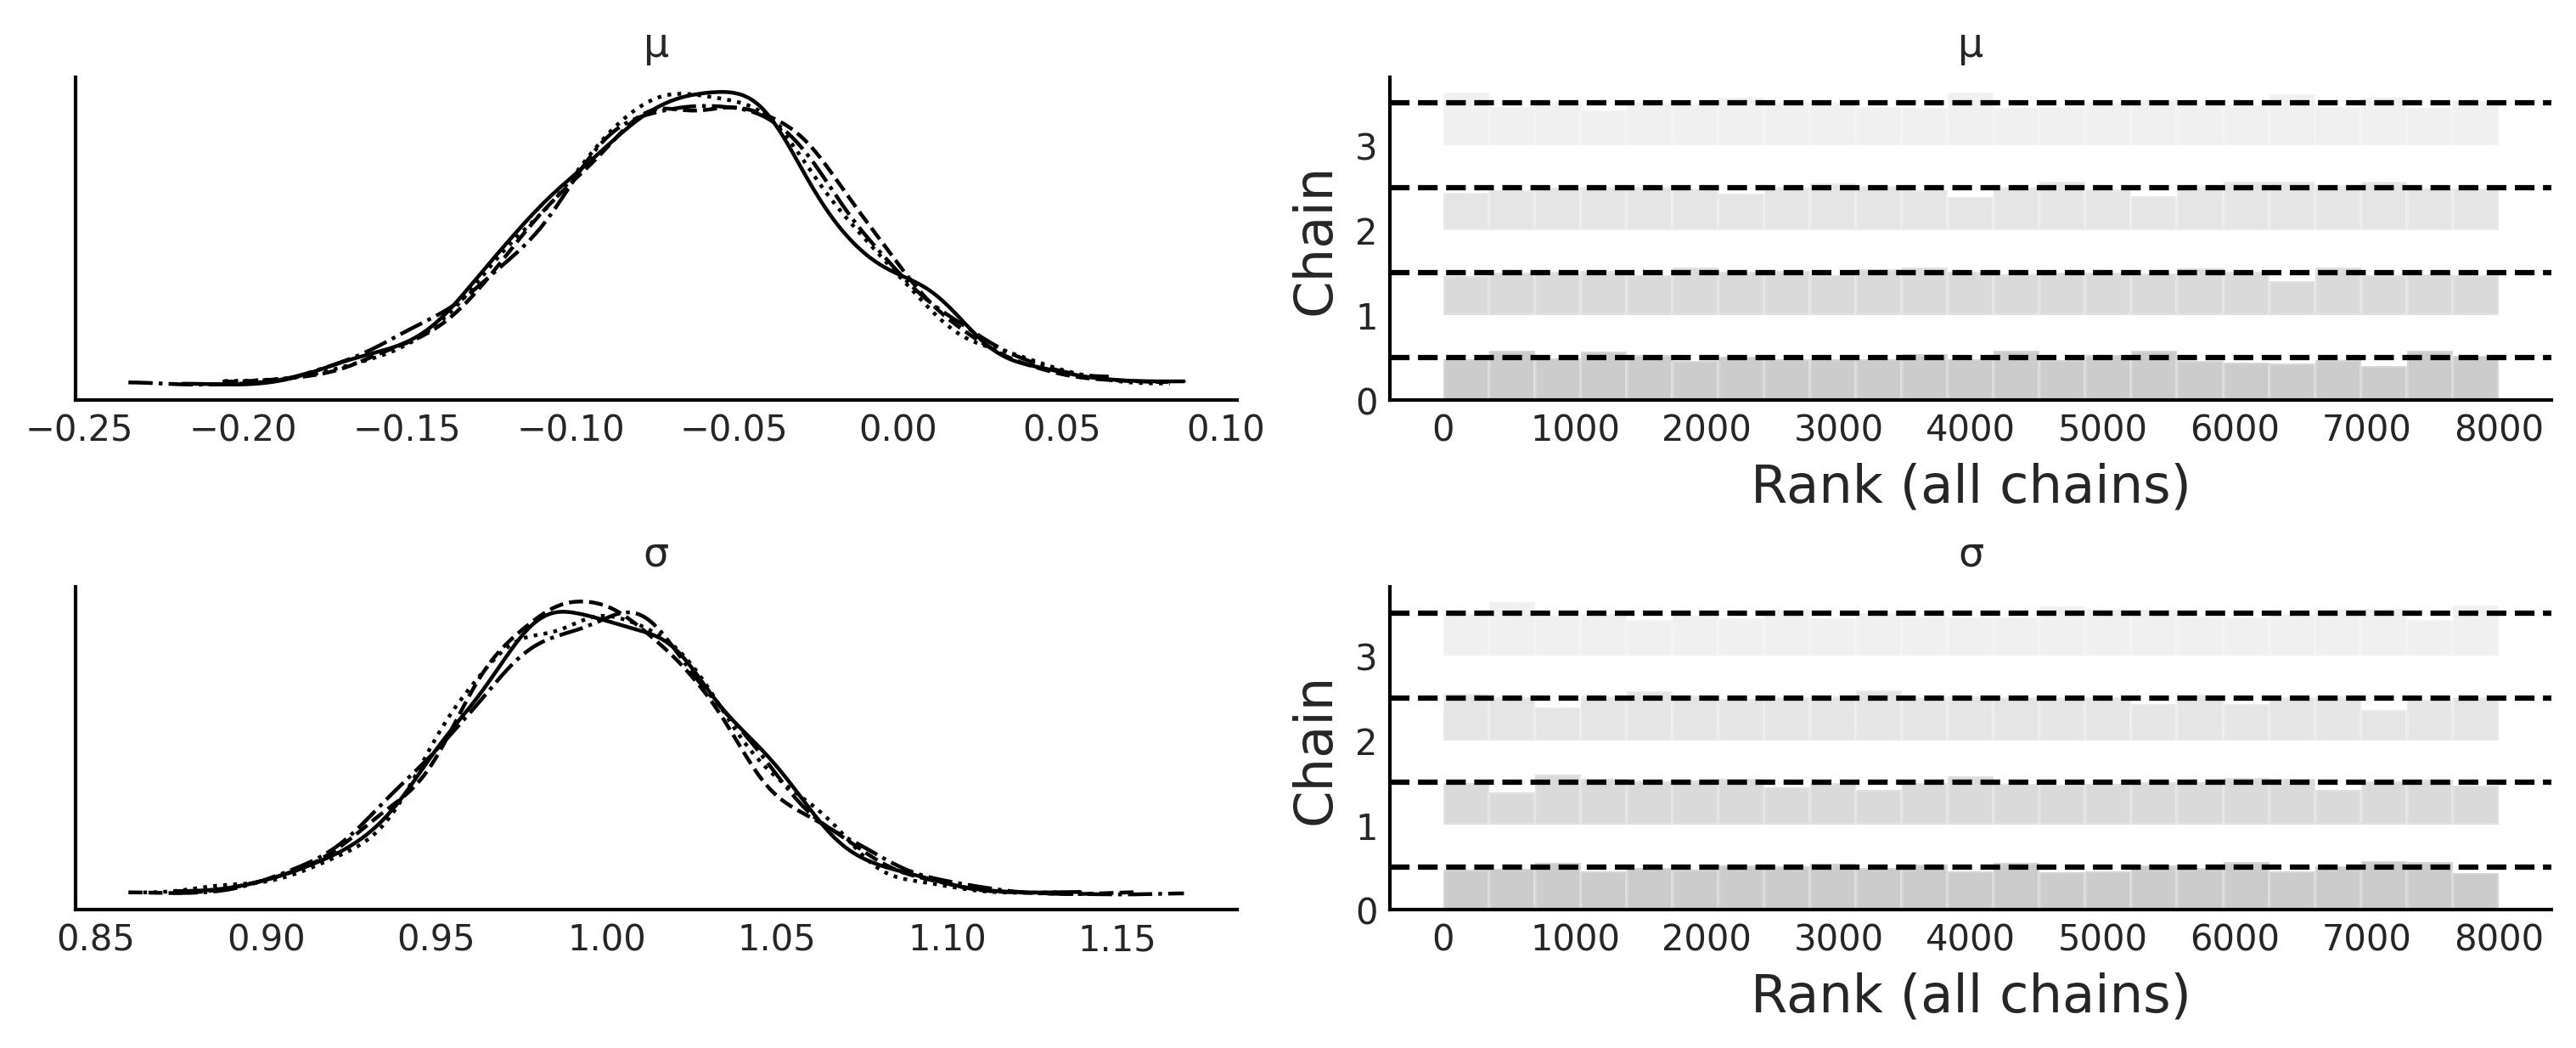

In [7]:
az.plot_trace(trace_g, kind="rank_bars", figsize=(10, 4));
plt.savefig('img/chp08/trace_g.png')

(choosing-the-distance-function-epsilon-and-the-summary-statistics)=

## 8.4. Choosing the Distance Function, $\epsilon$ and the Summary Statistics

Defining a useful distance, summary statistic and $\epsilon$ is problem
dependent. This means that we should expect some trial and error before
getting good results, especially when jumping into a new problem. As
usual thinking first about good options helps to reduce the number of
choices. But we should embrace running experiments too as they are
always helpful to better understand the problem and to make a more
informed decision about these hyperparameters. In the following sections
we will discuss a few general guidelines.

(choosing-the-distance)=

### 8.4.1. Choosing the Distance

We run Code Block [gauss_abc](gauss_abc) with the default
distance function `distance="gaussian"`, which is defined as:

```{math} 
:label: eq:euclidean_abc
\sum_i - \frac{||X_{oi} - X_{si}||^2}{2 \epsilon_i^2}

```

Where $X_{o}$ is the observed data, $X_{s}$ is the simulated data and
$\epsilon$ its scaling parameter. We call {eq}`eq:euclidean_abc`
*Gaussian* because it is the Gaussian kernel[^4] in log scale. We use
the log scale to compute pseudo-likelihood as we did with actual
likelihoods (and priors)[^5]. $||X_{oi} - X_{si}||^2$ is the Euclidean
distance (also known as L2 norm) and hence we can also describe Equation
{eq}`eq:euclidean_abc` as a weighted Euclidean distance. This is a very
popular choice in the literature. Other popular options are the L1 norm
(the sum of absolute differences), called Laplace distance in PyMC3, the
L$\infty$ norm (the maximum absolute value of the differences) or the
Mahalanobis distance: $\sqrt{(xo - xs)^{T}\Sigma(xo - xs)}$, where
$\Sigma$ is a covariance matrix.

Distances such as Gaussian, Laplace, etc can be applied to the whole
data or, as we already mentioned, to summary statistics. There are also
some distance functions that have been introduced specifically to avoid
the need of summary statistics and still provide good results
{cite:p}`Perez2008, Jiang2018, Bernton_2019`. We are going to discuss two of
them, the Wasserstein distances and the KL divergence.

In Code Block [gauss_abc](gauss_abc) we use
`sum_stat="sort"` [^6], this tells PyMC3 to sort the data before
computing Equation {eq}`eq:euclidean_abc`. Doing this is equivalent to
computing the 1D 2-Wasserstein distance and if we do the same but we use
the L1 norm we get the 1D 1-Wasserstein distance. It is possible to
define Wasserstein distances for dimensions larger than 1
{cite:p}`Bernton_2019`.

Sorting the data before computing the distance makes the comparison
between distributions much more fair. To see this imagine we have two
samples that are exactly equal, but out of pure luck one is ordered from
low to high and the other from high to low. In such a case if we apply a
metric like Equation {eq}`eq:euclidean_abc` we would conclude both
samples are very dissimilar, even when they are the same sample. But if
we sort first, we will conclude they are the same. This is a very
extreme scenario but it helps clarify the intuition behind sorting the
data. One more thing, if we sort the data we are assuming we only care
about the distribution and not the order of the data, otherwise sorting
will destroy the structure in the data. This could happen, for example,
with a time series, see Chapter [6](chap4).

Another distance introduced to avoid the need to define a summary
statistic is the use of the KL divergence (see Section {ref}`DKL`). The KL
divergence is approximated using the following expression
{cite:p}`Perez2008, Jiang2018`:

```{math} 
:label: eq:kl_abc
\frac{d}{n}  \sum \left(- \frac{\log(\frac{\nu_d}{\rho_d})}{\epsilon} \right) + \log\left(\frac{n}{n-1}\right)

```

Where $d$ is the dimension of the dataset (number of variables or
features), $n$ is the number of observed datapoints. $\nu_d$ contains
the 1-nearest neighbor distances of the observed to simulated data and
$\rho_d$ the 2-nearest neighbor distances of the observed data to itself
(notice that if you compare a dataset with itself the 1-nearest neighbor
distances will always be zero). As this method involves 2n operations of
nearest neighbor search, it is generally implemented using k-d trees
{cite:p}`Bentley1975`.

[^4]: Is similar to the Gaussian distribution but without the
    normalization term $\frac{1}{\sigma\sqrt{2\pi}}$.

[^5]: This is something PyMC3 does, other packages could be different

[^6]: Even when PyMC3 uses `sum_stat="sort"` as summary statistic,
    sorting is not a true summary as we are still using the whole data

(choosing-epsilon)=

### 8.4.2. Choosing $\epsilon$

In many ABC methods the $\epsilon$ parameter works as a hard-threshold,
$\theta$ values generating samples with distance larger than $\epsilon$
are rejected. Additionally $\epsilon$ can be a list of decreasing values
that the user has to set or the algorithm adaptive finds [^7].

In PyMC3, $\epsilon$ is the scale of the distance function, like in
Equation {eq}`eq:euclidean_abc`, so it does not work as a
hard-threshold. We can set $\epsilon$ according to our needs. We can
choose a scalar value (which is equivalent to setting $\epsilon_i$ equal
for all $i$). This is useful when evaluating the distance over the data
instead of using summary statistics. In this case a reasonably educated
guess could be the empirical standard deviation of the data. If we
instead use a summary statistic then we can set $\epsilon$ to a list of
values. This is usually necessary as each summary statistic may have a
different scale. If the scales are too different then the contribution
of each summary statistic will be uneven, it may even occur that a
single summary statistic dominates the computed distances. A popular
choice for $\epsilon$ in those cases is the empirical standard deviation
of the $i^{\text{th}}$ summary statistic under the prior predictive distribution,
or the median absolute deviation, as this is more robust to outliers. A
problem with using the prior predictive distribution is that it can be
way broader than the posterior predictive distribution. Thus to find a
useful value of $\epsilon$ we may want to take these educated guesses
previously mentioned as upper bound and then from those values try also
a few lower values. Then we could choose a final value of $\epsilon$
based on several factors including the computational cost, the needed
level of precision/error and the efficiency of the sampler. In general
the lower the value of $\epsilon$ the better the approximation.
{numref}`fig:trace_g_many_eps` shows a forest plot for $\mu$ and
$\sigma$ for several values of $\epsilon$ and also for the "NUTS"
sampler (using a normal likelihood instead of a simulator).

```{figure} figures/trace_g_many_eps.png
:name: fig:trace_g_many_eps
:width: 8.00in
Forest plot for $\mu$ and $\sigma$, obtained using NUTS or ABC with
increasing values of $\epsilon$, 1, 5, and 10.
```

Decreasing the value of $\epsilon$ has a limit, a too low value will
make the sampler very inefficient, signaling that we are aiming at an
accuracy level that does not make too much sense.
{numref}`fig:trace_g_eps_too_low` shows how the SMC sampler fails to
converge when the model from Code Block
[gauss_abc](gauss_abc) is sampled with a value of
`epsilon=0.1`. As we can see the sampler fails spectacularly.

```{figure} figures/trace_g_eps_too_low.png
:name: fig:trace_g_eps_too_low
:width: 8.00in
KDE and rank plot for model `trace_g_001`, failure of convergence could
indicate that the value $\epsilon=0.1$ is too low for this problem.
```

[^7]: In a similar fashion as the $\beta$ parameters in the description
    of the SMC/SMC-ABC algorithm explained before                               

In [8]:
with pm.Model() as gauss_001:
    μ = pm.Normal('μ', mu=0, sigma=1)
    σ = pm.HalfNormal('σ', sigma=1)
    s = pm.Simulator('s', normal_sim, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=0.1,
                     observed=data)
    idata_g_001 = pm.sample_smc(chains=4)
    idata_g_001.extend(pm.sample_posterior_predictive(idata_g_001))

with pm.Model() as gauss_01:
    μ = pm.Normal('μ', mu=0, sigma=1)
    σ = pm.HalfNormal('σ', sigma=1)
    s = pm.Simulator('s', normal_sim, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=1,
                     observed=data)
    idata_g_01 = pm.sample_smc(chains=4)
    idata_g_01.extend(pm.sample_posterior_predictive(idata_g_01))

    
with pm.Model() as gauss_02:
    μ = pm.Normal('μ', mu=0, sigma=1)
    σ = pm.HalfNormal('σ', sigma=1)
    s = pm.Simulator('s', normal_sim, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=2,
                     observed=data)
    idata_g_02 = pm.sample_smc(chains=4)
    idata_g_02.extend(pm.sample_posterior_predictive(idata_g_02))

with pm.Model() as gauss_05:
    μ = pm.Normal('μ', mu=0, sigma=1)
    σ = pm.HalfNormal('σ', sigma=1)
    s = pm.Simulator('s', normal_sim, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=5,
                     observed=data)
    idata_g_05 = pm.sample_smc(chains=4)
    idata_g_05.extend(pm.sample_posterior_predictive(idata_g_05))
    
with pm.Model() as gauss_10:
    μ = pm.Normal('μ', mu=0, sigma=1)
    σ = pm.HalfNormal('σ', sigma=1)
    s = pm.Simulator('s', normal_sim, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=10,
                     observed=data)
    idata_g_10 = pm.sample_smc(chains=4)
    idata_g_10.extend(pm.sample_posterior_predictive(idata_g_10))


with pm.Model() as gauss_NUTS:
    μ = pm.Normal('μ', mu=0, sigma=1)
    σ = pm.HalfNormal('σ', sigma=1)
    s = pm.Normal('s', μ, σ, observed=data)
    idata_g_nuts = pm.sample(chains=4)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [s]


Output()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

Sampling: [s]


Output()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

Sampling: [s]


Output()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [s]


Output()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [s]


Output()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


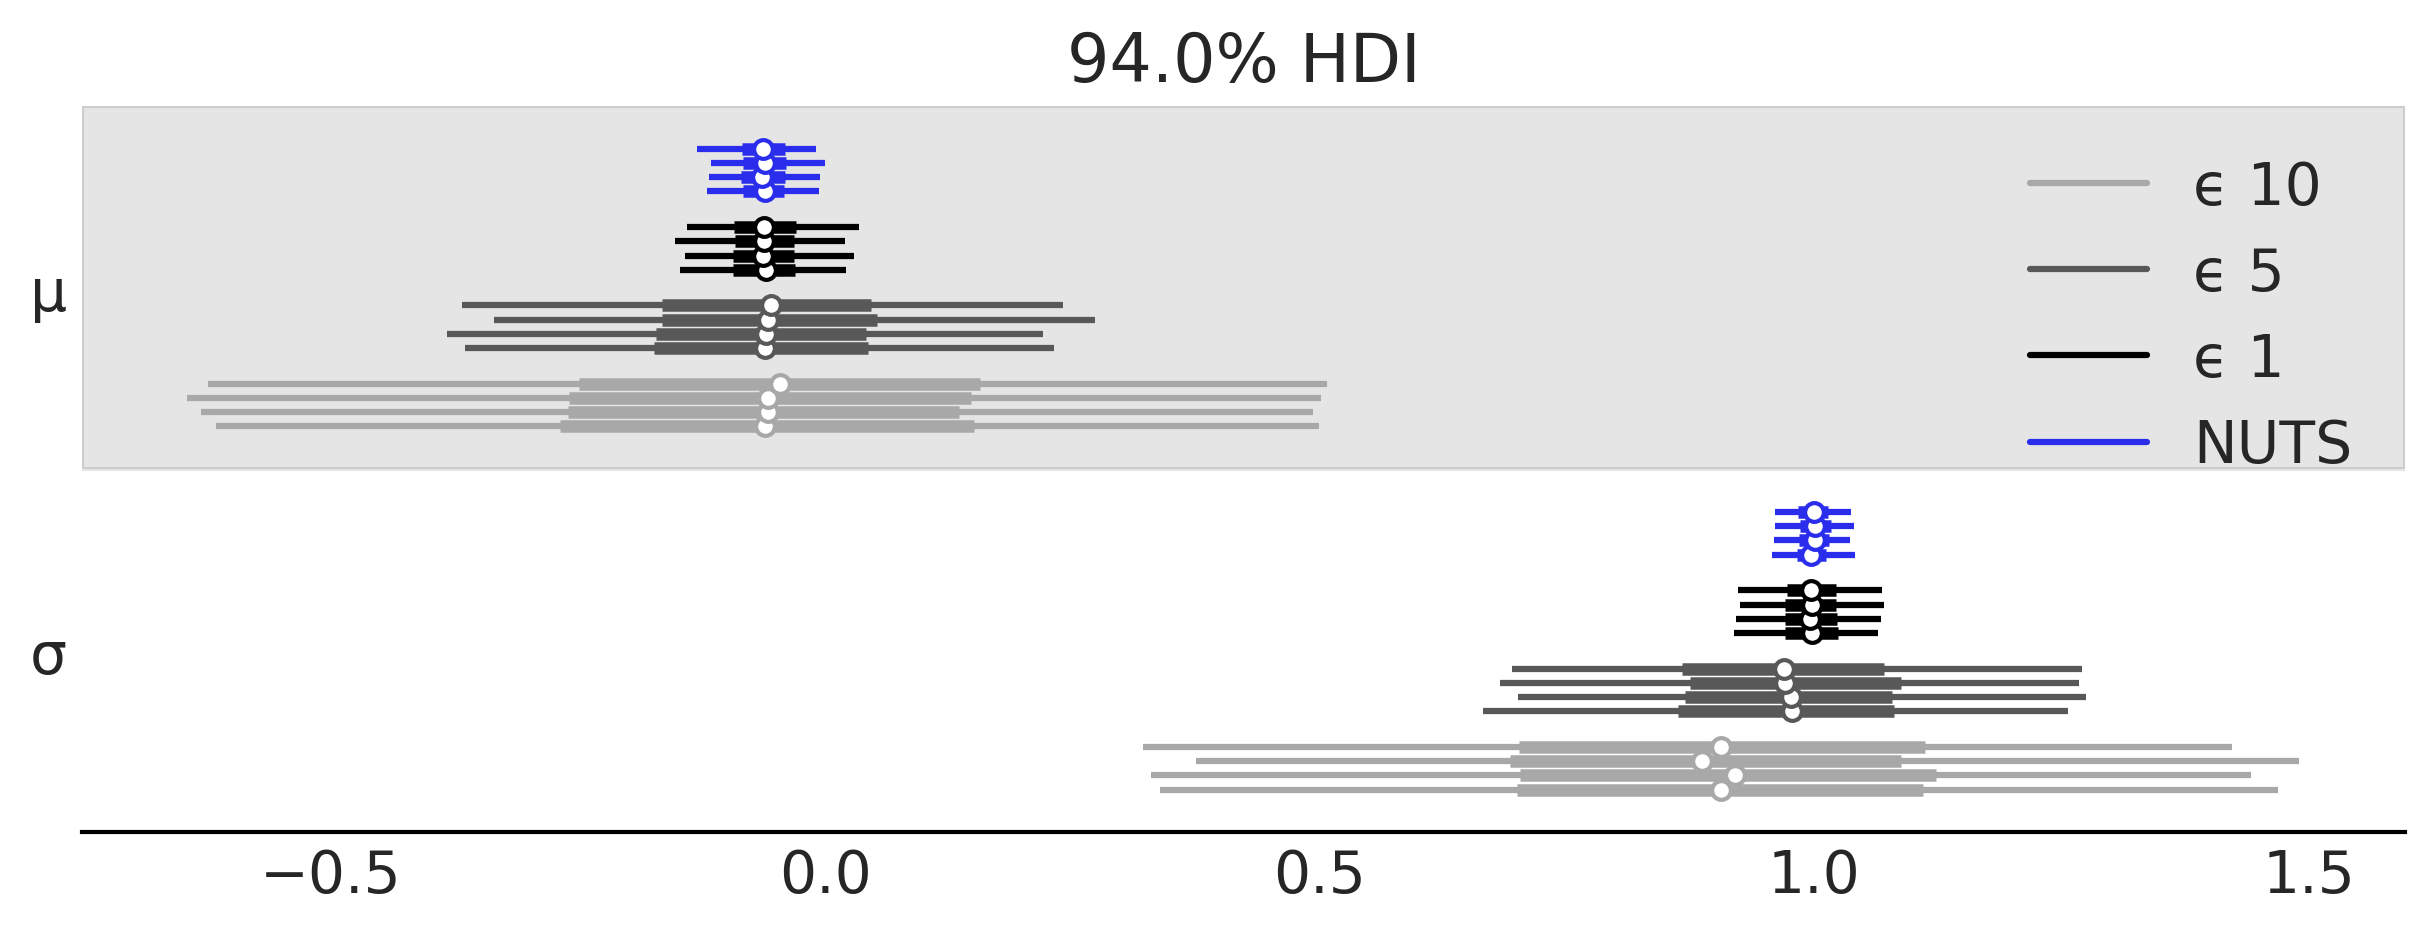

In [9]:
idatas = [idata_g_nuts, idata_g_01, idata_g_05, idata_g_10]
az.plot_forest(idatas, model_names=["NUTS", "ϵ 1", "ϵ 5", "ϵ 10"],
               colors=["#2a2eec", "#000000", "#585858", "#A8A8A8"],
               figsize=(8, 3));
plt.savefig("img/chp08/trace_g_many_eps.png")

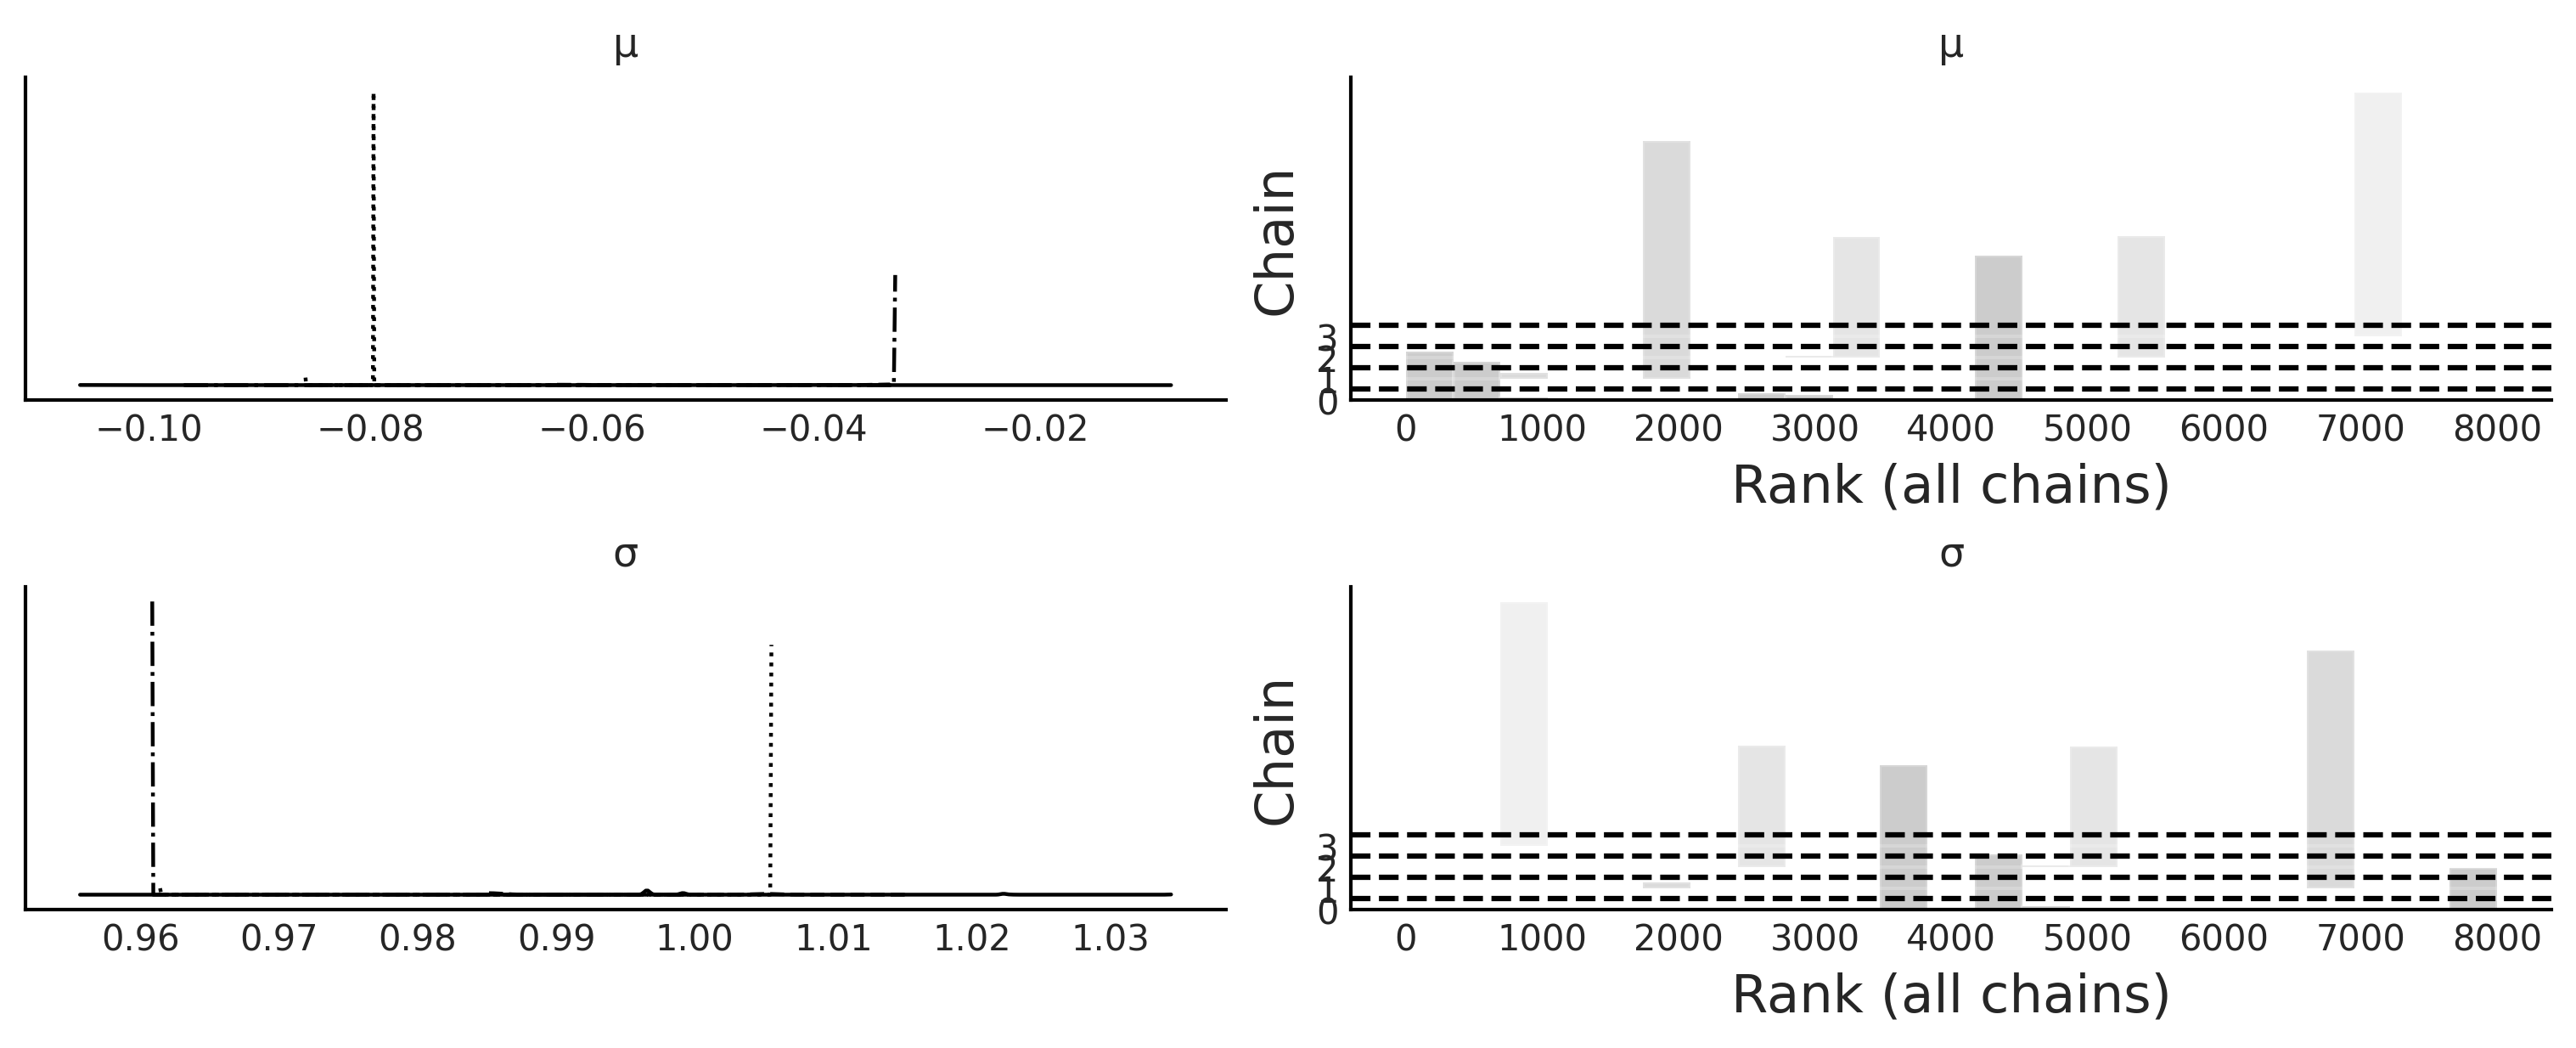

In [10]:
az.plot_trace(idata_g_001, kind="rank_bars", figsize=(10, 4));
plt.savefig("img/chp08/trace_g_eps_too_low.png")

To help us decide on a good value for $\epsilon$ we can get help from
the model criticism tools we have been using for non-ABC methods, like
Bayesian p-values and posterior predictive checks as exemplified in
Figures {numref}`fig:bpv_g_many_eps_00`,
{numref}`fig:bpv_g_many_eps_01`, and {numref}`fig:ppc_g_many_eps`.
{numref}`fig:bpv_g_many_eps_00` includes the value $\epsilon=0.1$. We do
that here to show what poorly calibrated models look like. But in
practice if we obtain a rank plot like the one in
{numref}`fig:trace_g_eps_too_low` we should stop right there with the
analysis of the computed posterior and reinspect the model definition.
Additionally, for ABC methods, we should also inspect the value of the
hyperparameter $\epsilon$, the summary statistics we have chosen or the
distance function.

```{figure} figures/bpv_g_many_eps_00.png
:name: fig:bpv_g_many_eps_00
:width: 8.00in
Distribution of marginal Bayesian p-values for increasing values of
$\epsilon$. For a well calibrated model we should expect a Uniform
distribution. We can see that for $\epsilon=0.1$ the calibration is
terrible, this is not surprising as this value of $\epsilon$ is too. For
all the other values of $\epsilon$ the distribution looks much more
Uniform and the level of uniformity decreases as $\epsilon$ increases.
The `se` values are the (scaled) squared differences between the
expected Uniform distribution and the computed KDEs.
```

```{figure} figures/bpv_g_many_eps_01.png
:name: fig:bpv_g_many_eps_01
:width: 8.00in
Bayesian p-values for increasing values of epsilon. The blue curve is
the observed distribution and the gray curves the expected ones. For a
well calibrated model we should expect a distribution concentrated
around 0.5. We can see that for $\epsilon=0.1$ the calibration is
terrible, this is not surprising as this value of $\epsilon$ is too low.
We can see that $\epsilon=1$ provides the best results.
```

```{figure} figures/ppc_g_many_eps.png
:name: fig:ppc_g_many_eps
:width: 8.00in
Posterior predictive checks for increasing values of $\epsilon$. The
blue curve is the observed distribution and the gray curves the expected
ones. Surprisingly from $\epsilon=0.1$ we get what seems to be a good
adjustment, even when we know that the samples from that posterior are
not trustworthy, this is a very simple example and we got the right
answer out of pure luck. This is an example of *a too good to be true
fit*. These are the worst! If we only consider models with posterior
samples that look reasonable (i.e. not $\epsilon=0.1$ ), we can see that
$\epsilon=1$ provides the best results.
```

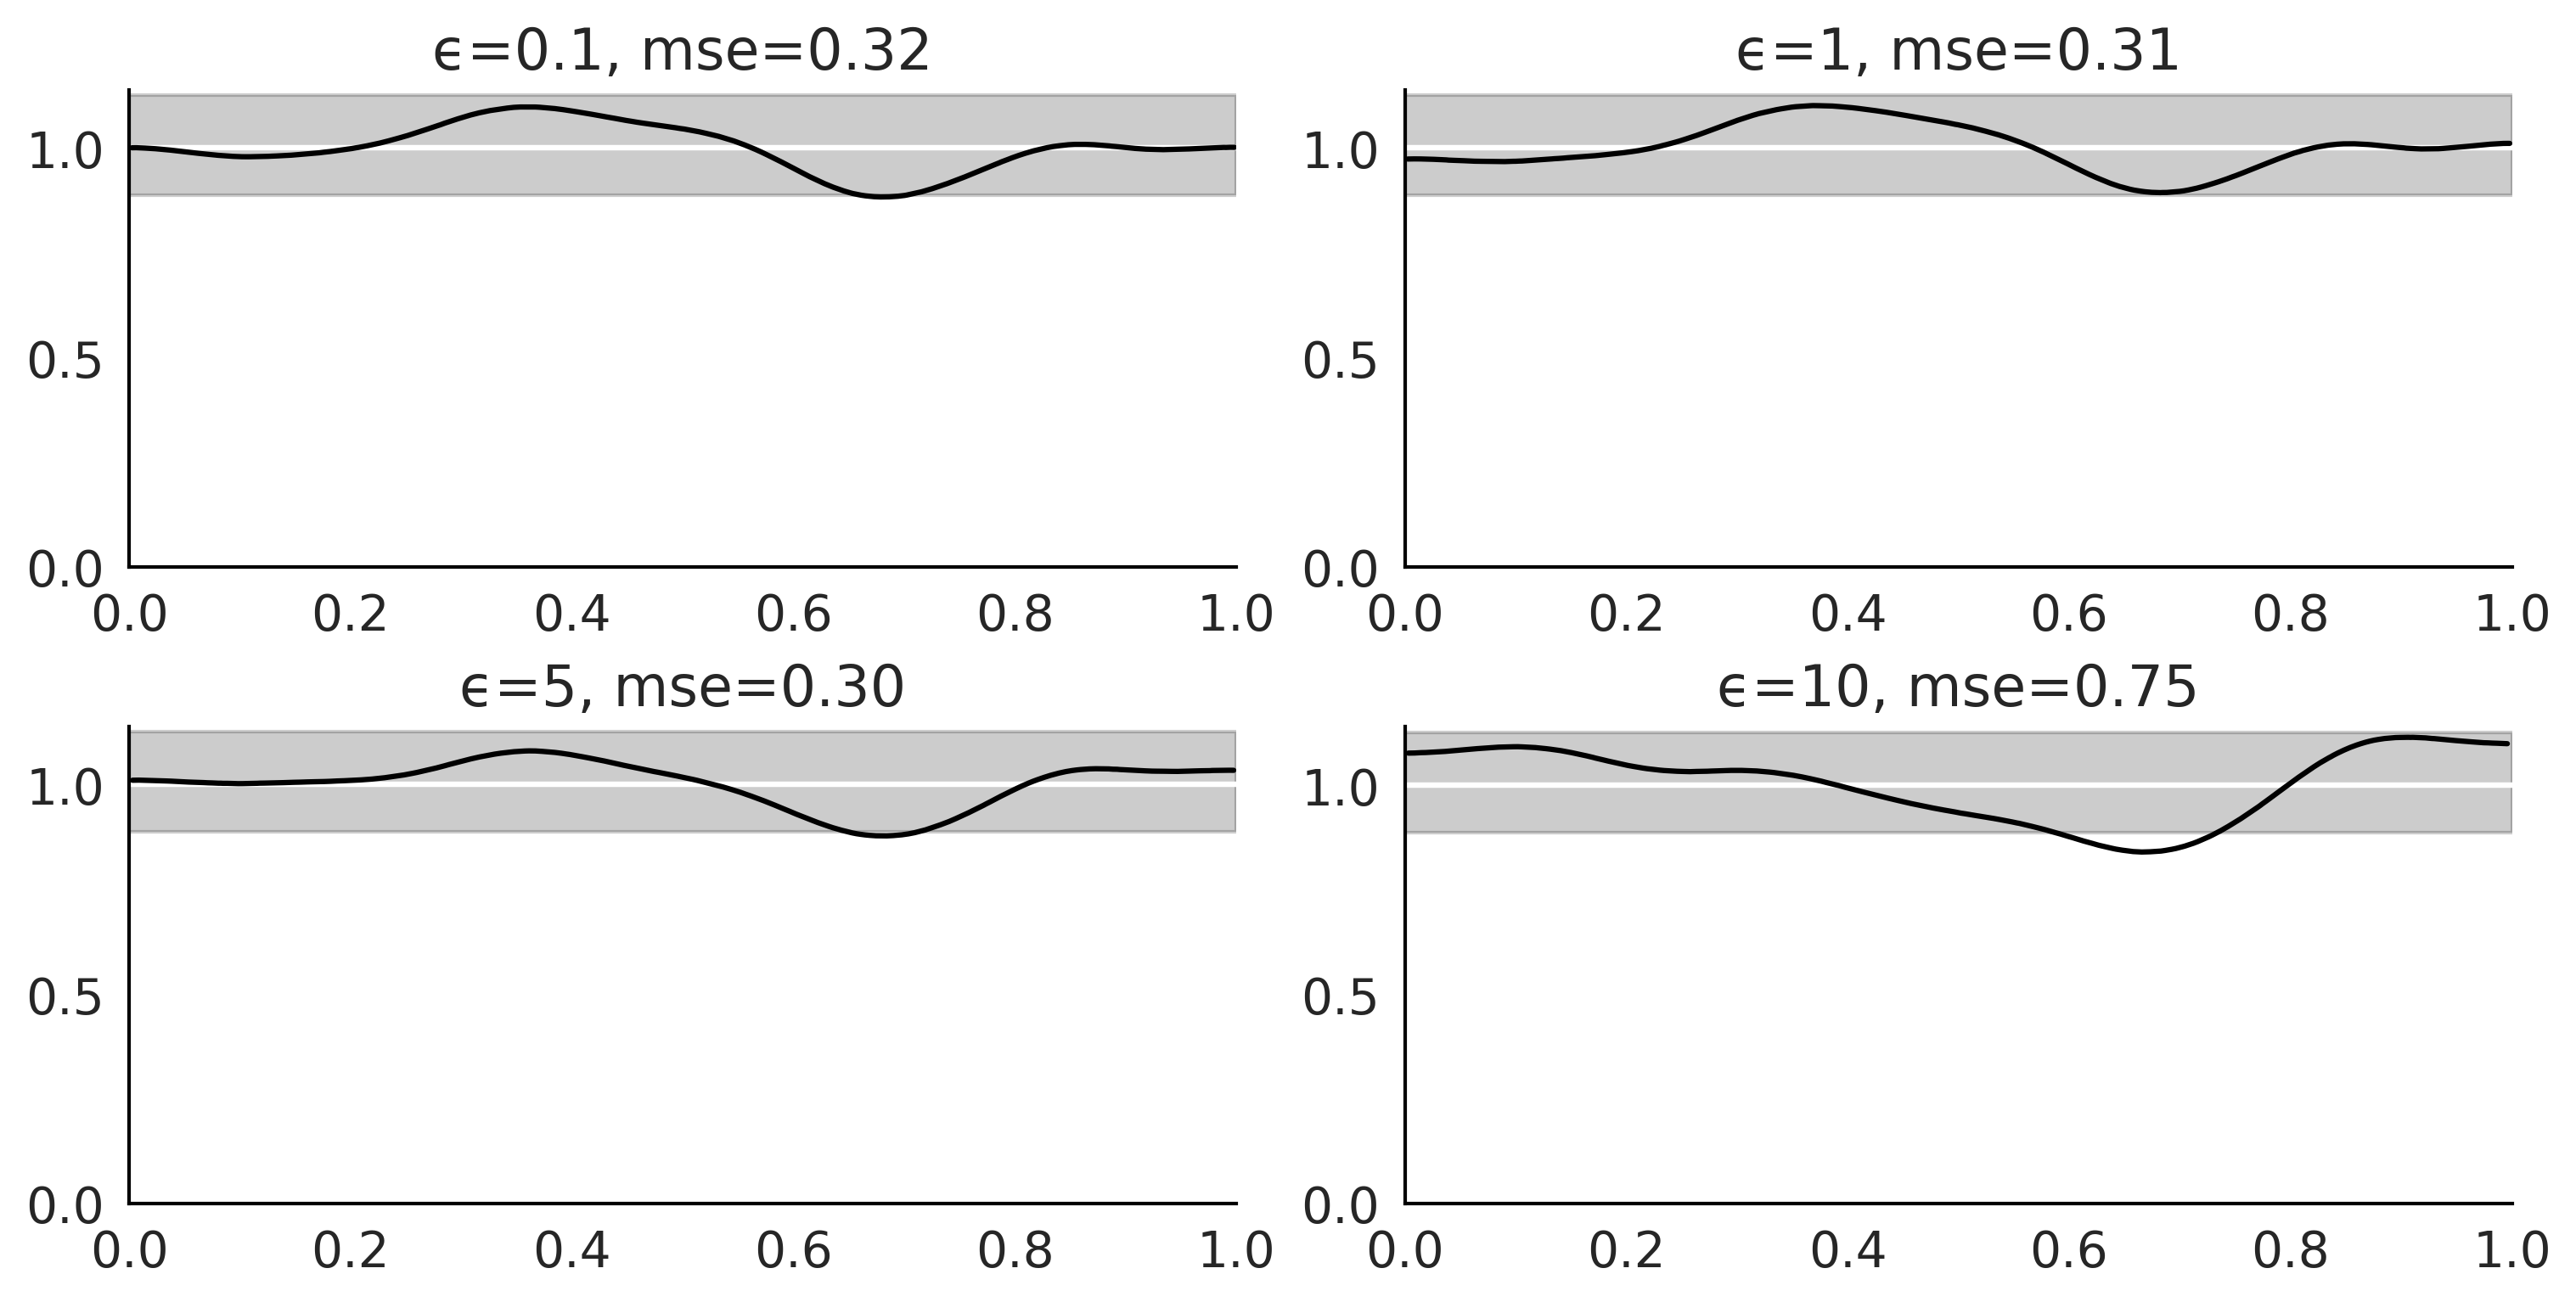

In [11]:
idatas_ = [idata_g_001, idata_g_01, idata_g_05, idata_g_10]
epsilons = [0.1, 1, 5, 10]

_, axes = plt.subplots(2, 2, figsize=(10,5))

for i, ax in enumerate(axes.ravel()):
    pp_vals = idatas_[i].posterior_predictive["s"].values.reshape(8000, -1)
    tstat_pit = np.mean(pp_vals <= data, axis=0)
    _, tstat_pit_dens = az.kde(tstat_pit)

    ax.axhline(1, color="w")
    az.plot_bpv(idatas_[i], kind="u_value", ax=ax, reference="analytical")
    ax.tick_params(axis='both', pad=7)
    ax.set_title(f"ϵ={epsilons[i]}, mse={np.mean((1 - tstat_pit_dens)**2) * 100:.2f}")

plt.savefig("img/chp08/bpv_g_many_eps_00.png")

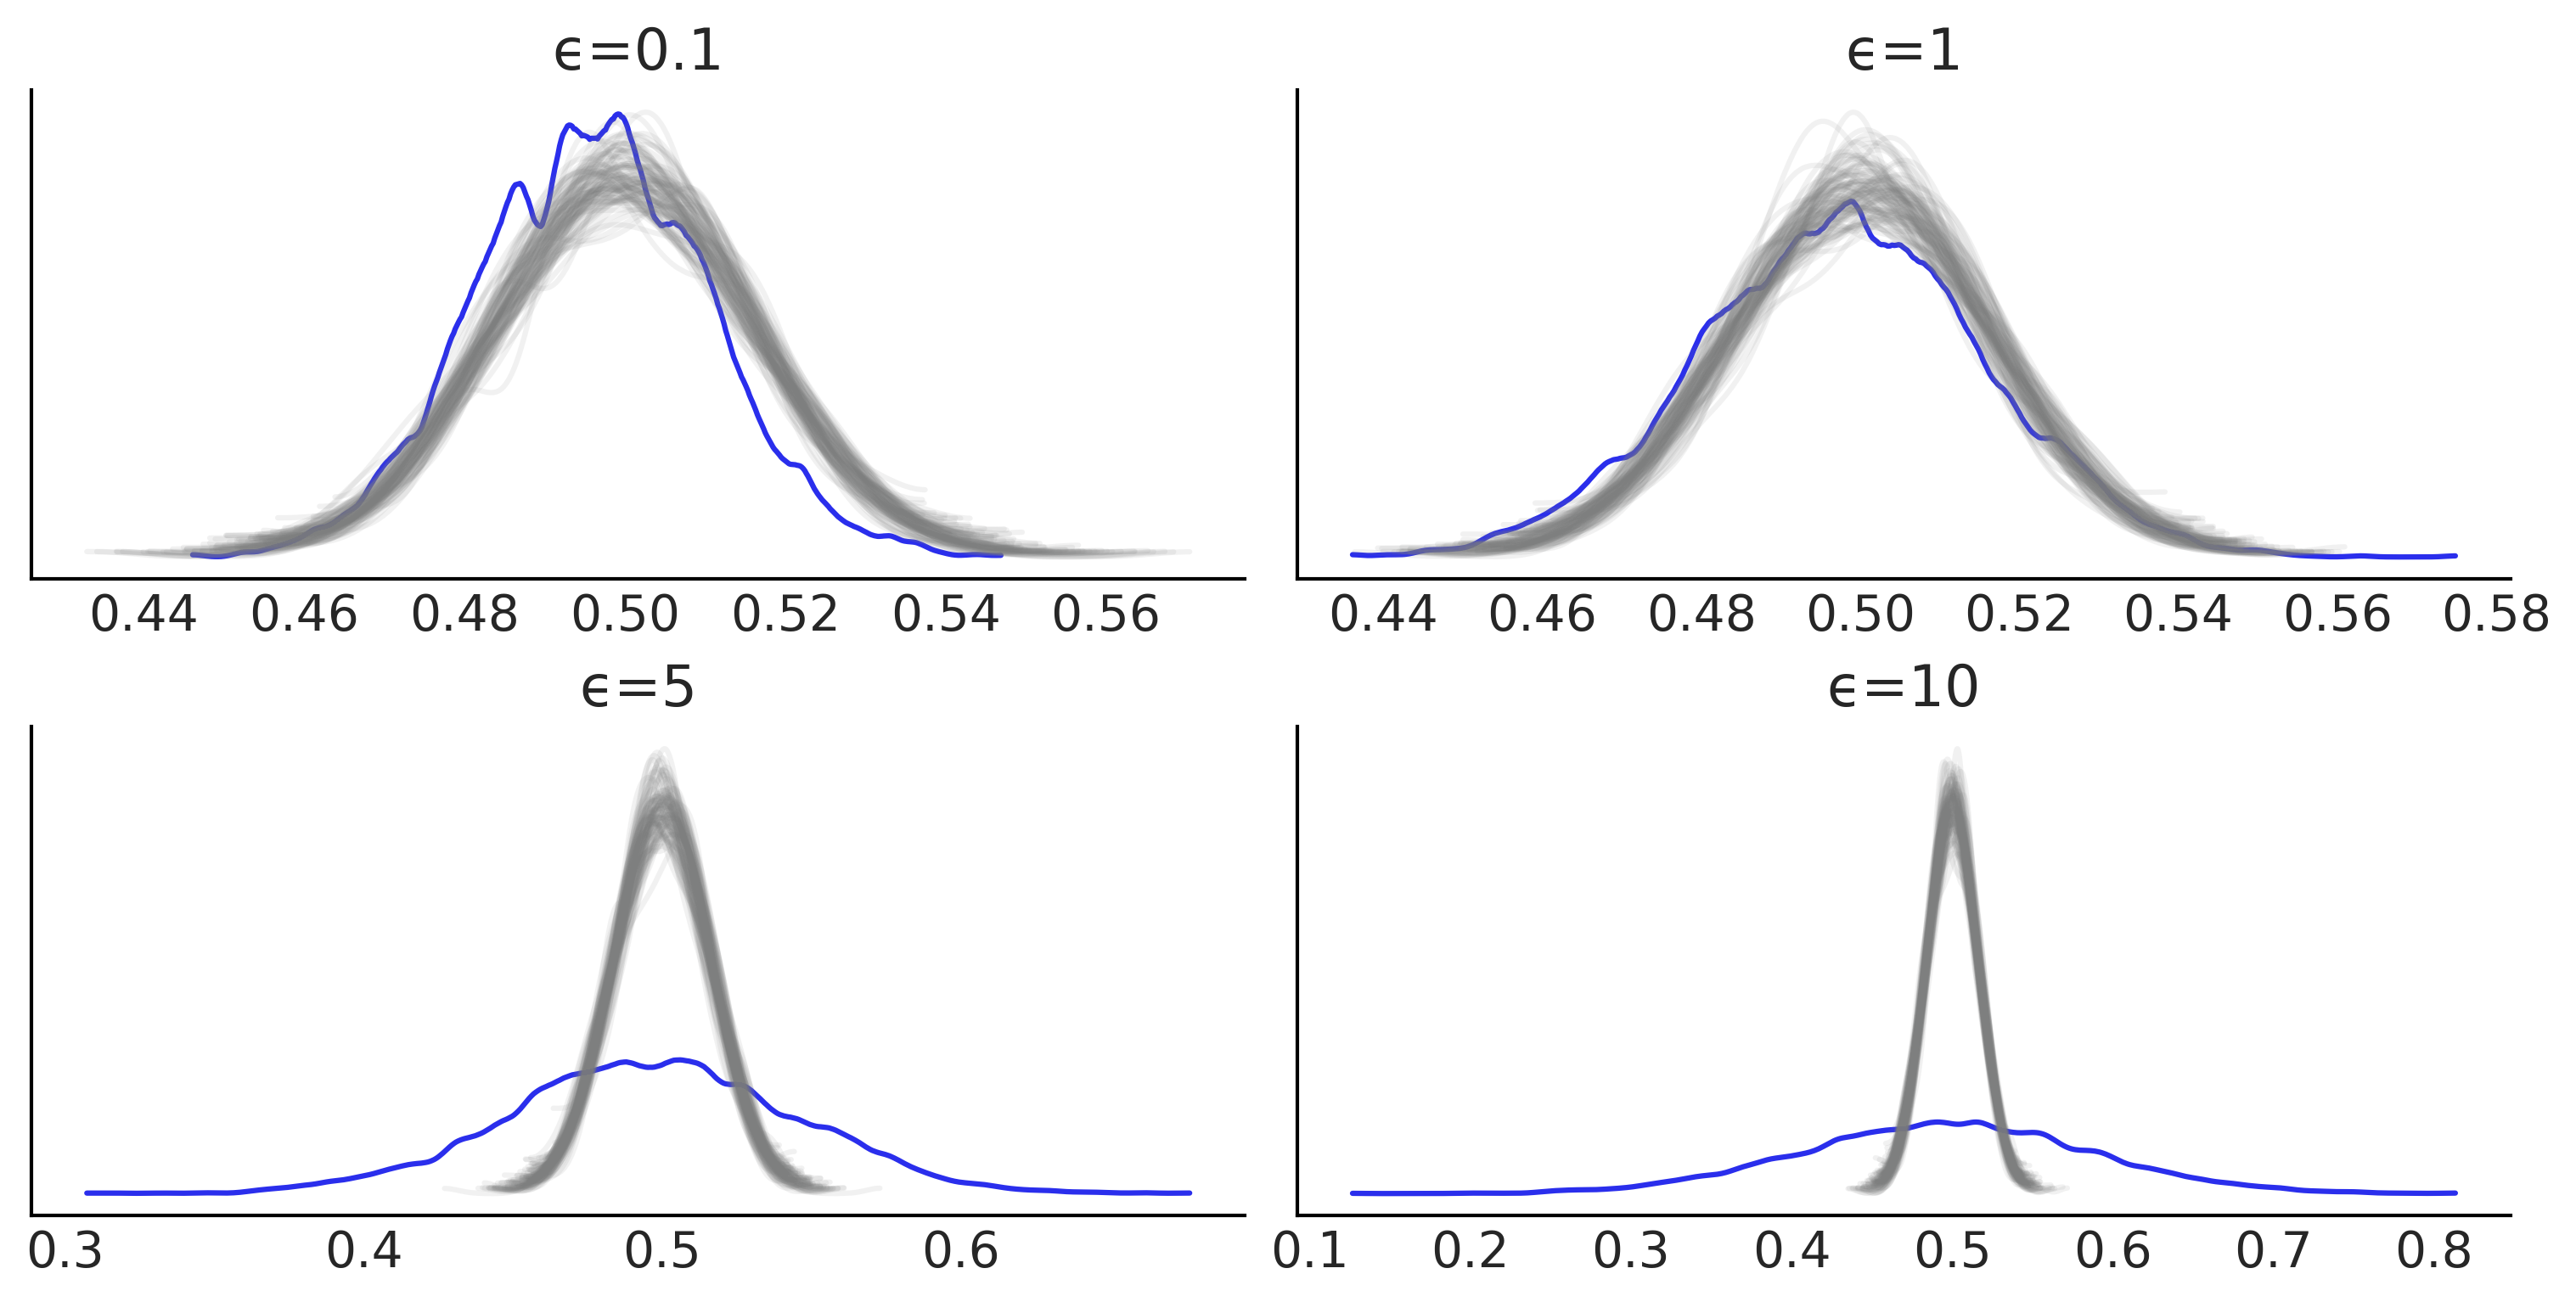

In [12]:
_, ax = plt.subplots(2, 2, figsize=(10,5))

ax = ax.ravel()
for i in range(4):
    az.plot_bpv(idatas_[i], kind="p_value", reference='samples', color="C4", ax=ax[i],
               plot_ref_kwargs={"color":"C2"})
    ax[i].set_title(f"ϵ={epsilons[i]}")
plt.savefig("img/chp08/bpv_g_many_eps_01.png")

/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/arviz/plots/ppcplot.py:242: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


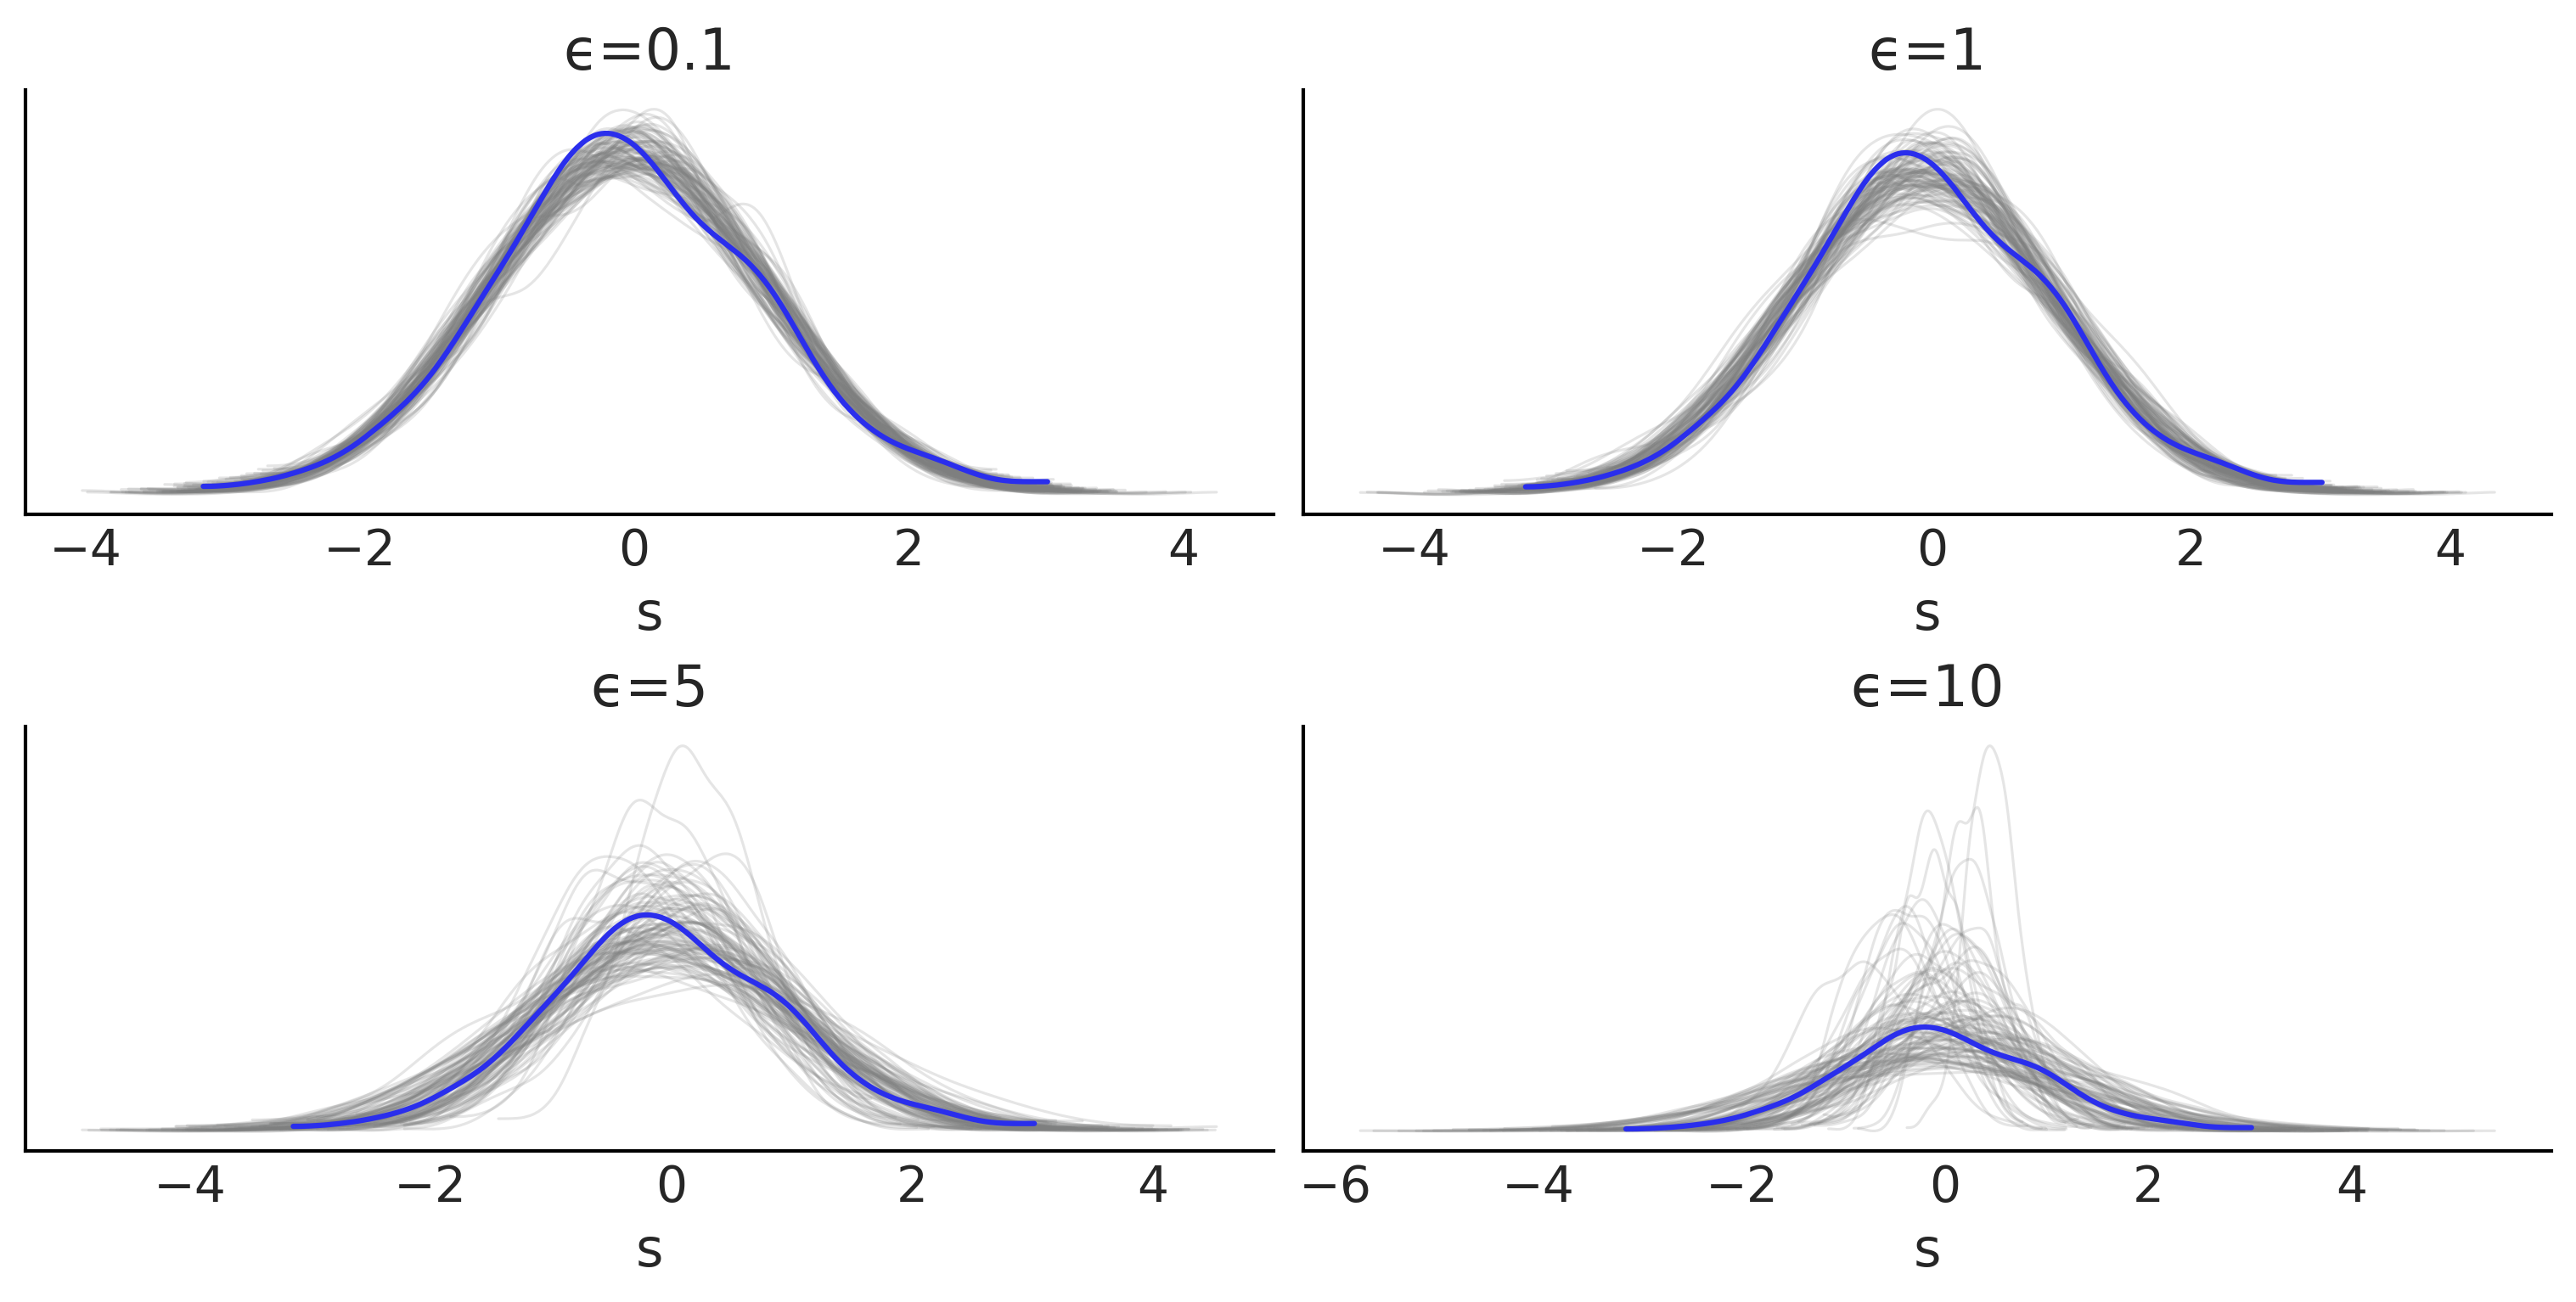

In [13]:
_, axes = plt.subplots(2, 2, figsize=(10,5))

for i, ax in enumerate(axes.ravel()):
    az.plot_ppc(idatas_[i], num_pp_samples=100, ax=ax, color="C2",
                mean=False, legend=False, observed=False)
    az.plot_kde(idatas_[i].observed_data["s"].values, plot_kwargs={"color":"C4"}, ax=ax)
    ax.set_xlabel("s")
    ax.set_title(f"ϵ={epsilons[i]}")
plt.savefig("img/chp08/ppc_g_many_eps.png")

(choosing-summary-statistics)=

### 8.4.3. Choosing Summary Statistics

The choice of summary statistics is arguably more difficult and will
have a larger effect than the choice of the distance function. For that
reason a lot of research has been focused on the subject from the use of
distance that does not require summary statistics
{cite:p}`Jiang2018, Bernton_2019` to strategies for choosing summary
statistics {cite:p}`Sisson2018`.

A good summary statistic provides a balance between low dimension and
informativeness. When we do not have a sufficient summary statistic it
is tempting to overcompensate by adding a lot of summary statistics. The
intuition is that the more information the better. However, increasing
the number of summary statistics can actually reduce the quality of the
approximated posterior {cite:p}`Sisson2018`. One explanation for this is that
we move from computing distances over data to distances over summaries
to reduce the dimensionality, by increasing the number of summaries
statistics we are defeating that purpose.

In some fields like population genetics, where ABC methods are very
common, people have developed a large collection of useful summary
statistics {cite:p}`Beaumont2002, Beaumont2010, Pudlo2015`. In general it is
a good idea to check the literature from the applied field you are
working on to see what others are doing, as chances are high they have
already tried and tested many alternatives.

When in doubt we can follow the same recommendations from the previous
section to evaluate the model fit, i.e rank plots, Bayesian p-values,
posterior predictive checks, etc and try alternatives if necessary (see
Figures {numref}`fig:trace_g_eps_too_low`,
{numref}`fig:bpv_g_many_eps_00`, {numref}`fig:bpv_g_many_eps_01`, and
{numref}`fig:ppc_g_many_eps`).

(g-and-k-distribution)=

## 8.5. g-and-k Distribution

Carbon monoxide (CO) is a colorless, odorless gas that can be harmful,
even fatal, when inhaled in large amounts. This gas is generated when
something is burned, especially in situations when oxygen levels are
low. CO together with other gases like Nitrogen Dioxide (NO₂) are
usually monitored in many cities around the world to assess the level of
air pollution and the quality of air. In a city the main sources of CO
are cars, and other vehicles or machinery that work by burning fossil
fuels. {numref}`fig:co_ppm_bsas` shows a histogram of the daily CO
levels measured by one station in the city of Buenos Aires from 2010 to 2018.
As we can see the data seems to be slightly right skewed.
Additionally the data present a few observations with very high values.
The bottom panel omits 8 observations between 3 and 30.

```{figure} figures/co_ppm_bsas.png
:name: fig:co_ppm_bsas
:width: 8.00in
Histogram of CO levels. The top panel shows the entire data and the
bottom one omits values larger than 3.
```

In [14]:
data = pd.read_csv("../data/air_pollution_bsas.csv")
bsas_co = data["co"].dropna().values

'We have 8 observations larger than 3 ppm'

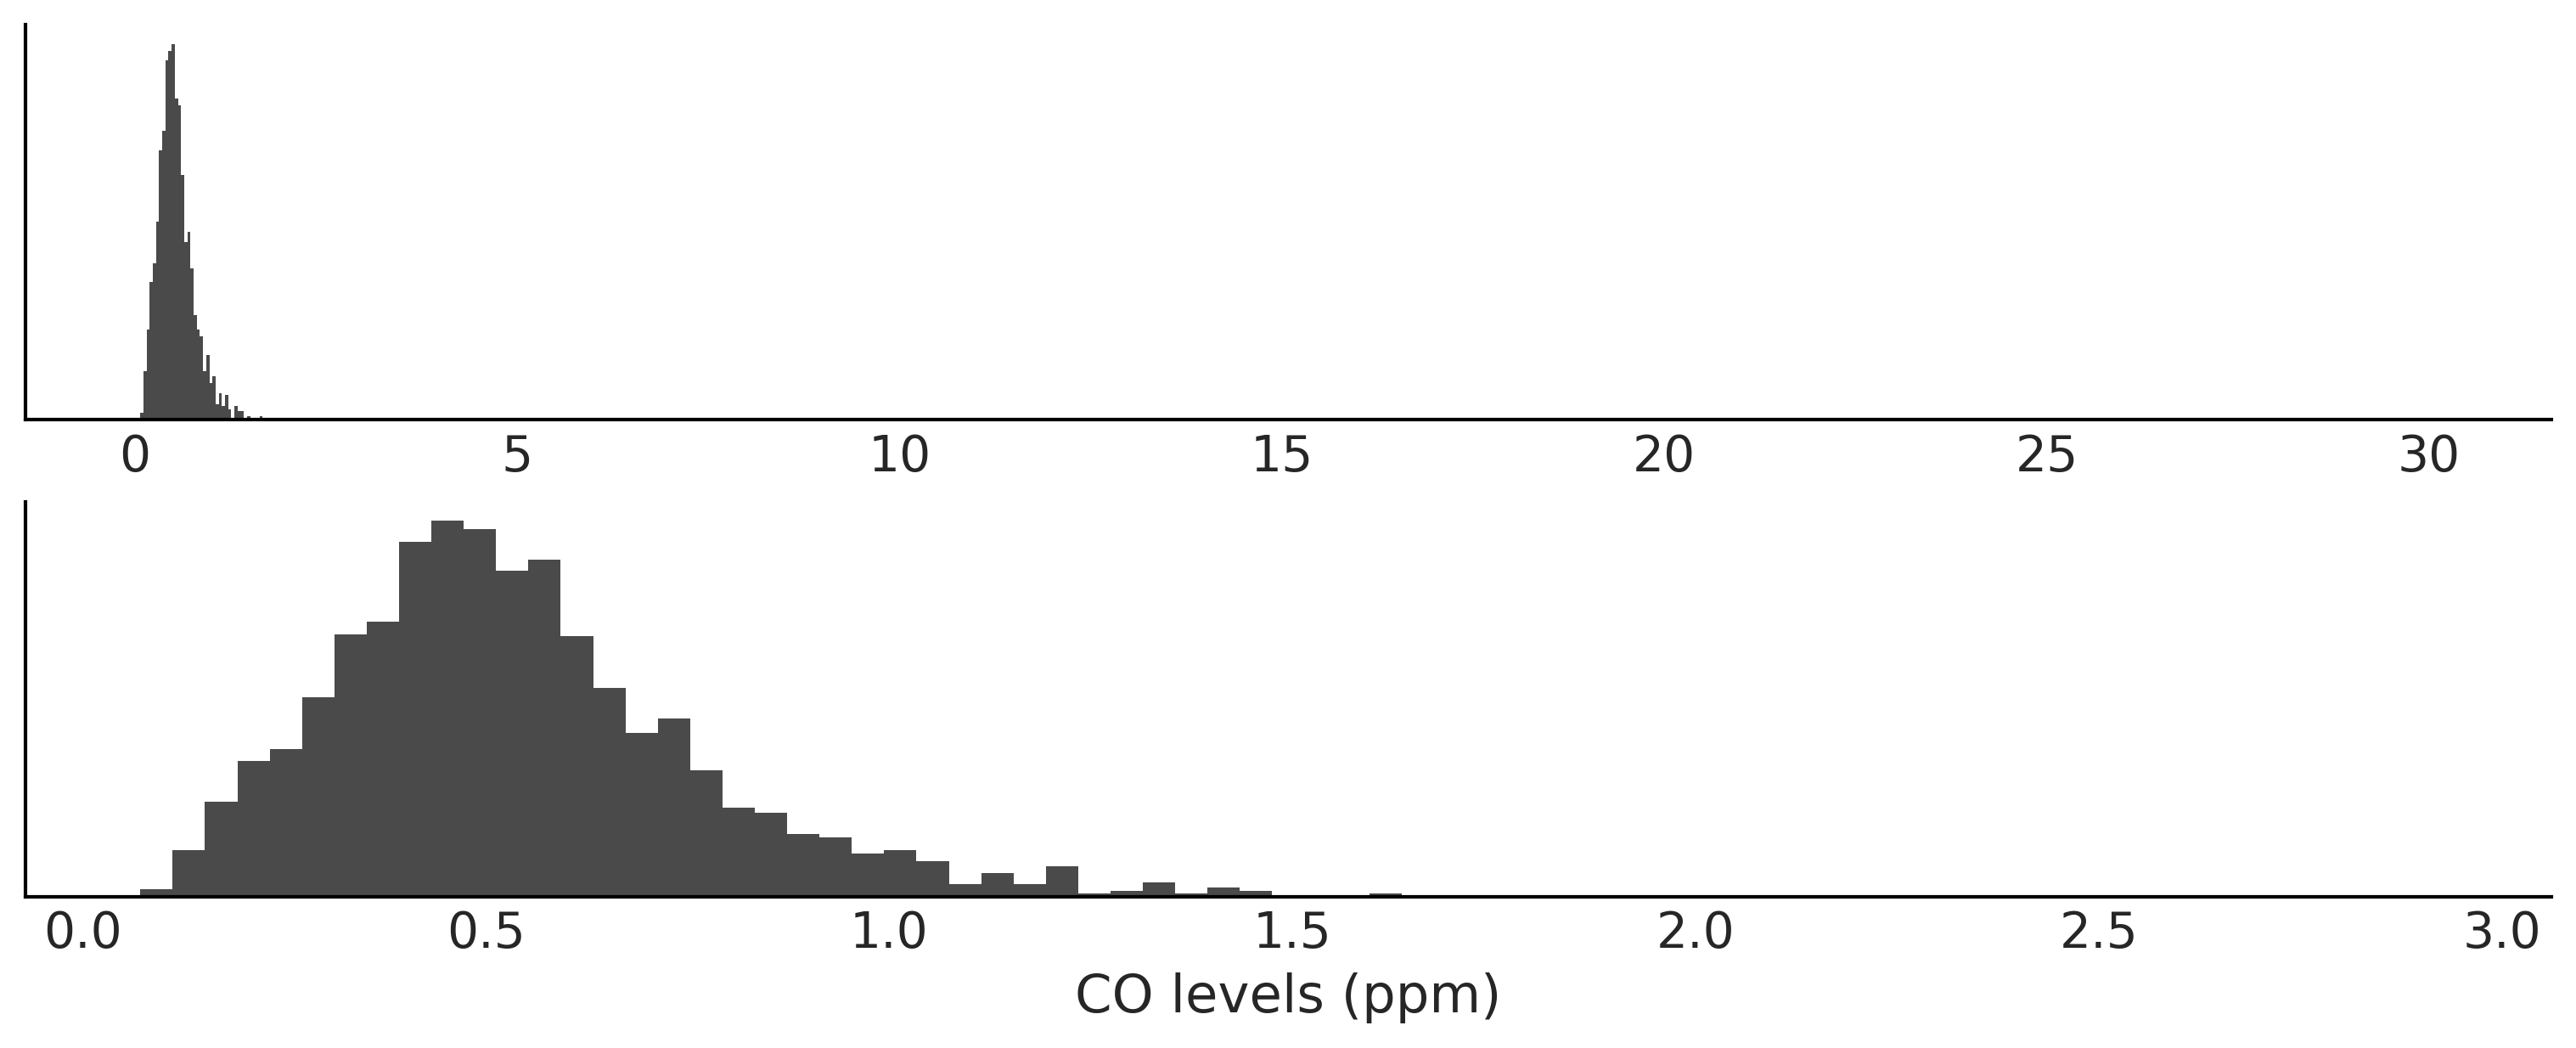

In [15]:
_, axes = plt.subplots(2,1,  figsize=(10,4), sharey=True)
axes[0].hist(bsas_co, bins="auto", color="C1", density=True)
axes[0].set_yticks([])
axes[1].hist(bsas_co[bsas_co < 3], bins="auto", color="C1", density=True)
axes[1].set_yticks([])
axes[1].set_xlabel("CO levels (ppm)")
plt.savefig("img/chp08/co_ppm_bsas.png")
f"We have {sum(bsas_co > 3)} observations larger than 3 ppm"

To fit this data we are going to introduce the univariate g-and-k
distribution. This is a 4 parameter distribution able to describe data
with high skewness and/or kurtosis {cite:p}`Tukey1977, Rayner2002`. Its
density function in unavailable in closed form and the g-and-k
distribution are defined through its quantile function, i.e. the inverse
of the cumulative distribution function:

```{math} 
:label: eq:g_and_k
a + b \ \left(1 + c \ \text{tanh}\left[\frac{gz(x)}{2}\right]\right) \left(1+z(x)^2\right)^k z(x)

```

where $z$ is the inverse of the standard normal cumulative distribution
function and $x \in (0,1)$.

The parameters $a$, $b$, $g$ and $k$ are the location, scale, skewness
and kurtosis parameters respectively. If $g$ and $k$ are 0, we recover
the Gaussian distribution with mean $a$ and standard deviation $b$.
$g > 0$ gives positive (right) skewness and $g < 0$ gives negative
(left) skewness. The parameter $k \geqslant 0$ gives longer tails than
the normal and $k < 0$ gives shorter tails than the normal. $a$ and $g$
can take any real value. It is common to restrict $b$ to be positive and
$k \geqslant -0.5$ or sometimes $k \geqslant 0$ i.e. tails as heavy or
heavier than those from a Gaussian distribution. Additionally it is
common to fix $c=0.8$. With all these restrictions we are guaranteed to
get a strictly increasing quantile function {cite:p}`Rayner2002` which is a
hallmark of well-defined continuous distribution functions.

Code Block [gk_quantile](gk_quantile) defines a g-and-k
quantile distribution. We have omitted the calculation of the cdf and
pdf because they are a little bit more involved, but most importantly
because we are not going to use them for our examples [^8]. While the
probability density function of the g-and-k distribution can be
evaluated numerically {cite:p}`Rayner2002, prangle2017`, simulating from the
g-and-k model using the inversion method is more straightforward and
fast {cite:p}`Drovandi2011, prangle2017`. To implement the inversion method we
sample $x \sim \mathcal{U}(0, 1)$ and replace in Equation
{eq}`eq:g_and_k`. Code Block [gk_quantile](gk_quantile)
shows how to do this in Python and {numref}`fig:gk_quantile` shows
examples of g-and-k distributions.


```{code-block} python
:name: gk_quantile
:caption: gk_quantile

class g_and_k_quantile:
    def __init__(self):
        self.quantile_normal = stats.norm(0, 1).ppf

    def ppf(self, x, a, b, g, k):
        z = self.quantile_normal(x)
        return a + b * (1 + 0.8 * np.tanh(g*z/2)) * ((1 + z**2)**k) * z

    def rvs(self, samples, a, b, g, k):
        x = np.random.normal(0, 1, samples)
        return ppf(self, x, a, b, g, k)
```

```{figure} figures/gk_quantile.png
:name: fig:gk_quantile
:width: 8.00in
The first row shows the quantile function, also known as the inverse of
the cumulative distribution function. You feed it with a quantile value
and it returns the value of the variable that represents that quantile.
For example, if you have $P(X <= x_q) = q$, you pass $q$ to the quantile
function and you get $x_q$. The second row shows the (approximated) pdf.
For this example the pdf has been computed using a kernel density
estimation from the random samples generated with Code Block
[gk_quantile](gk_quantile).
```

[^8]: In Prangle {cite:p}`prangle2017` you will find a description of an R
    package with a lot of functions to work with g-and-k distributions.

In [16]:
class g_and_k_quantile:
    def __init__(self):
        self.quantile_normal = stats.norm(0, 1).ppf
        self.pdf_normal = stats.norm(0, 1).pdf

    def ppf(self, x, a, b, g, k):
        z = self.quantile_normal(x)
        return a + b * (1 + 0.8 * np.tanh(g*z/2)) * ((1 + z**2)**k) * z

    
    def rvs(self, rng, a, b, g, k, size):
        x = rng.uniform(0, 1, size)
        return self.ppf(x, a, b, g, k)

    def cdf(self, x, a, b, g, k, zscale=False):   
        optimize.fminbound(f, -5, 5)

    def pdf(self, x, a, b, g, k):
        #z = cdf(x, a, b, g, k)
        z = x
        z_sq = z**2
        term1 = (1+z_sq)**k
        term2 = 1+0.8*np.tanh(g*x/2)
        term3 = (1+(2*k+1)*z_sq)/(1+z_sq)
        term4 = 0.8*g*z/(2*np.cosh(g*z/2)**2)

        deriv = b*term1*(term2*term3+term4)
        return self.pdf_normal(x) / deriv

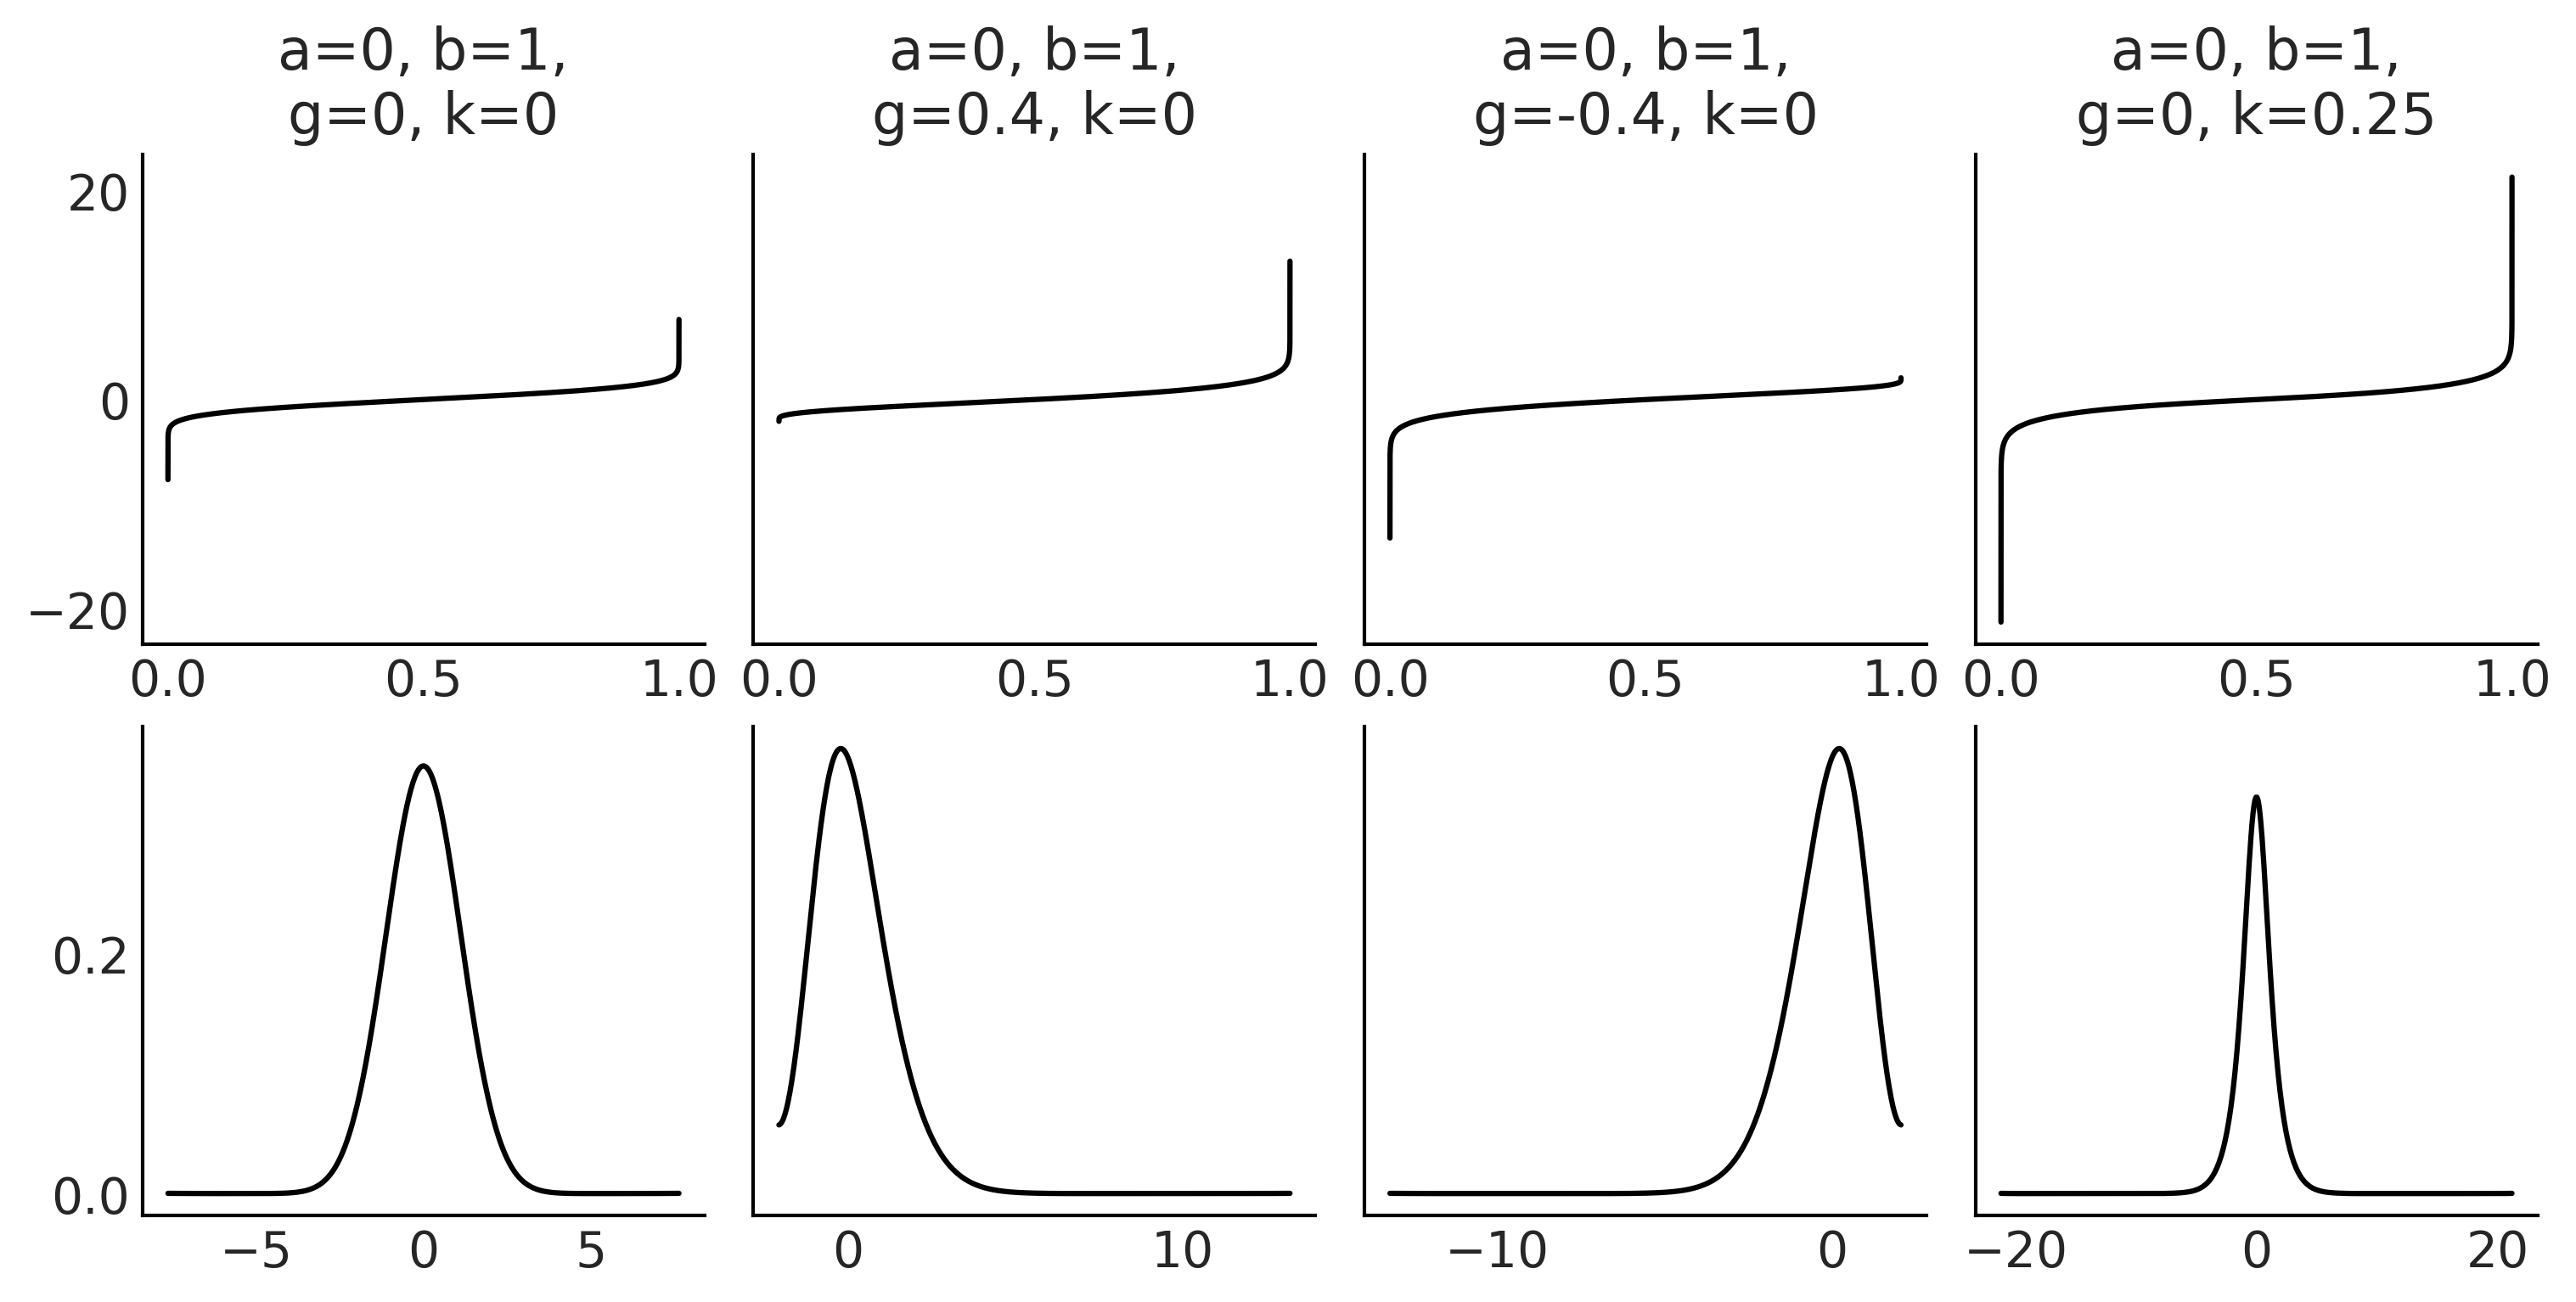

In [17]:
gk = g_and_k_quantile()
u = np.linspace(1E-14, 1-1E-14, 10000)

params = ((0, 1, 0, 0), 
 (0, 1, .4, 0),
 (0, 1,-.4, 0),
 (0, 1, 0, 0.25))

_, ax = plt.subplots(2, 4, sharey="row", figsize=(10, 5))
for i, p in enumerate(params):
    a, b, g, k = p
    ppf = gk.ppf(u, a, b, g, k)
    ax[0, i].plot(u, ppf)
    ax[0, i].set_title(f"a={a}, b={b},\ng={g}, k={k}")
    #ax[1, i].plot(x, gk.pdf(x, a, b, g, k))
    az.plot_kde(ppf, ax=ax[1, i], bw=0.5)
plt.savefig("img/chp08/gk_quantile.png")

To fit a g-and-k distribution using SMC-ABC, we can use the Gaussian
distance and `sum_stat="sort"` as we did for the Gaussian example.
Alternative, we can also think of a summary statistic tailored for this
problem. As we know, the parameters $a$, $b$, $g$ and $k$ are associated
with location, scale, skewness and kurtosis respectively. Thus, we can
think of a summary statistic based on robust estimates for these
quantities {cite:p}`Drovandi2011`:

```{math}
:label: eq:octiles
\begin{split}
sa &= e4 \\
sb &= e6 - e2 \\  
sg &= (e6 + e2 - 2*e4)/sb \\ 
sk &= (e7 - e5 + e3 - e1)/sb \\
\end{split}
```

where $e1$ to $e7$ are octiles, i.e. the quantiles that divide a sample
into eight subsets.

If we pay attention we can see that $sa$ is the median and $sb$ the
interquartile range, which are robust estimators of location and
dispersion. Even when $sg$ and $sk$ may look a little bit more obscure,
they are also robust estimators of skewness {cite:p}`Bowley1920` and kurtosis
{cite:p}`Moors1988`, respectively. Let us make this more clear. For a symmetric
distribution $e6-e4$ and $e2-e4$ will have the same magnitude but
opposite signs so in such a case $sg$ will be zero, and for skewed
distributions either $e6-e4$ will be larger than $e2-e4$ or vice versa.
The two terms in the numerator of $sk$ increase when the mass in the
neighbourhood of $e6$ and $e2$ decreases, i.e. when we *move* mass from
the central part of the distribution to the tails. The denominator in
both $sg$ and $sk$ acts as a normalization factor.

With this idea in mind we can use Python to create a summary statistic
for our problem as specified in the following code block.

```python
def octo_summary(x):
    e1, e2, e3, e4, e5, e6, e7 = np.quantile(
        x, [.125, .25, .375, .5, .625, .75, .875])
    sa = e4
    sb = e6 - e2
    sg = (e6 + e2 - 2*e4)/sb
    sk = (e7 - e5 + e3 - e1)/sb
    return np.array([sa, sb, sg, sk])
```

In [18]:
def octo_summary(x):
    e1, e2, e3, e4, e5, e6, e7 = np.quantile(x, [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875])
    sa = e4
    sb = e6 - e2
    sg = (e6 + e2 - 2*e4)/sb
    sk = (e7 - e5 + e3 - e1)/sb
    return np.array([sa, sb, sg, sk])

Now we need to define a simulator, we can just wrap the `rvs` method
from the `g_and_k_quantile()` function previously defined in Code Block
[gk_quantile](gk_quantile).

```python
gk = g_and_k_quantile()
def gk_simulator(a, b, g, k):
    return gk.rvs(len(bsas_co), a, b, g, k)
```

In [19]:
gk = g_and_k_quantile()
def gk_simulator(rng, a, b, g, k, size=None):
    return gk.rvs(rng, a, b, g, k, len(bsas_co))

Having defined the summary statistic and the simulator and having
imported the data, we can define our model. For this example we use
weakly informative priors based on the fact that all the parameters are
restricted to be positive. CO levels can not take negative values so $a$
is positive and $g$ is also expected to be 0 or positive as most common
levels are expected to be "low", with some measurement taking larger
values. We also have reasons to assume that the parameters are most
likely to be below 1.

```python
with pm.Model() as gkm:
    a = pm.HalfNormal("a", sigma=1)
    b = pm.HalfNormal("b", sigma=1)
    g = pm.HalfNormal("g", sigma=1)
    k = pm.HalfNormal("k", sigma=1)
    
    s = pm.Simulator("s", gk_simulator,
    params=[a, b, g, k],        
                     sum_stat=octo_summary,
                     epsilon=0.1,
                     observed=bsas_co)
    
    trace_gk = pm.sample_smc(kernel="ABC", parallel=True)
```

{numref}`fig:plot_pair` shows a pair plot of the fitted `gkm` model.

```{figure} figures/pair_gk.png
:name: fig:plot_pair
:width: 8.00in
The distribution is slightly skewed and with some degree of kurtosis as
expected from the few CO levels with values one or two orders of
magnitude larger than the bulk of CO values. We can see that $b$ and $k$
are (slightly) correlated. This is expected, as the density in the tail
(kurtosis) increases, the dispersion increases, but the g-and-k
distribution can keep $b$ small if $k$ increases. It is like $k$ is
*absorbing* part of the dispersion, similar to what we observed with the
scale and the $\nu$ parameter in a Student's t-distribution.
```

In [20]:
with pm.Model() as gkm:
    a = pm.HalfNormal('a', sigma=1)
    b = pm.HalfNormal('b', sigma=1)
    g = pm.HalfNormal('g', sigma=1)
    k = pm.HalfNormal('k', sigma=1)
    
    s = pm.Simulator('s', gk_simulator, params=[a, b, g, k],        
                     sum_stat=octo_summary,
                     epsilon=0.1,
                     observed=bsas_co)
    
    idata_gk = pm.sample_smc(chains=4)
    idata_gk.extend(pm.sample_posterior_predictive(idata_gk))

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

Sampling: [s]


Output()

In [21]:
az.summary(idata_gk)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  0.503  0.099   0.320    0.690      0.001    0.001    7435.0    7834.0   
b  0.195  0.071   0.065    0.332      0.001    0.001    6712.0    5985.0   
g  0.447  0.291   0.002    0.940      0.003    0.002    6208.0    4065.0   
k  0.144  0.086   0.001    0.292      0.001    0.001    6055.0    2868.0   

   r_hat  
a    1.0  
b    1.0  
g    1.0  
k    1.0

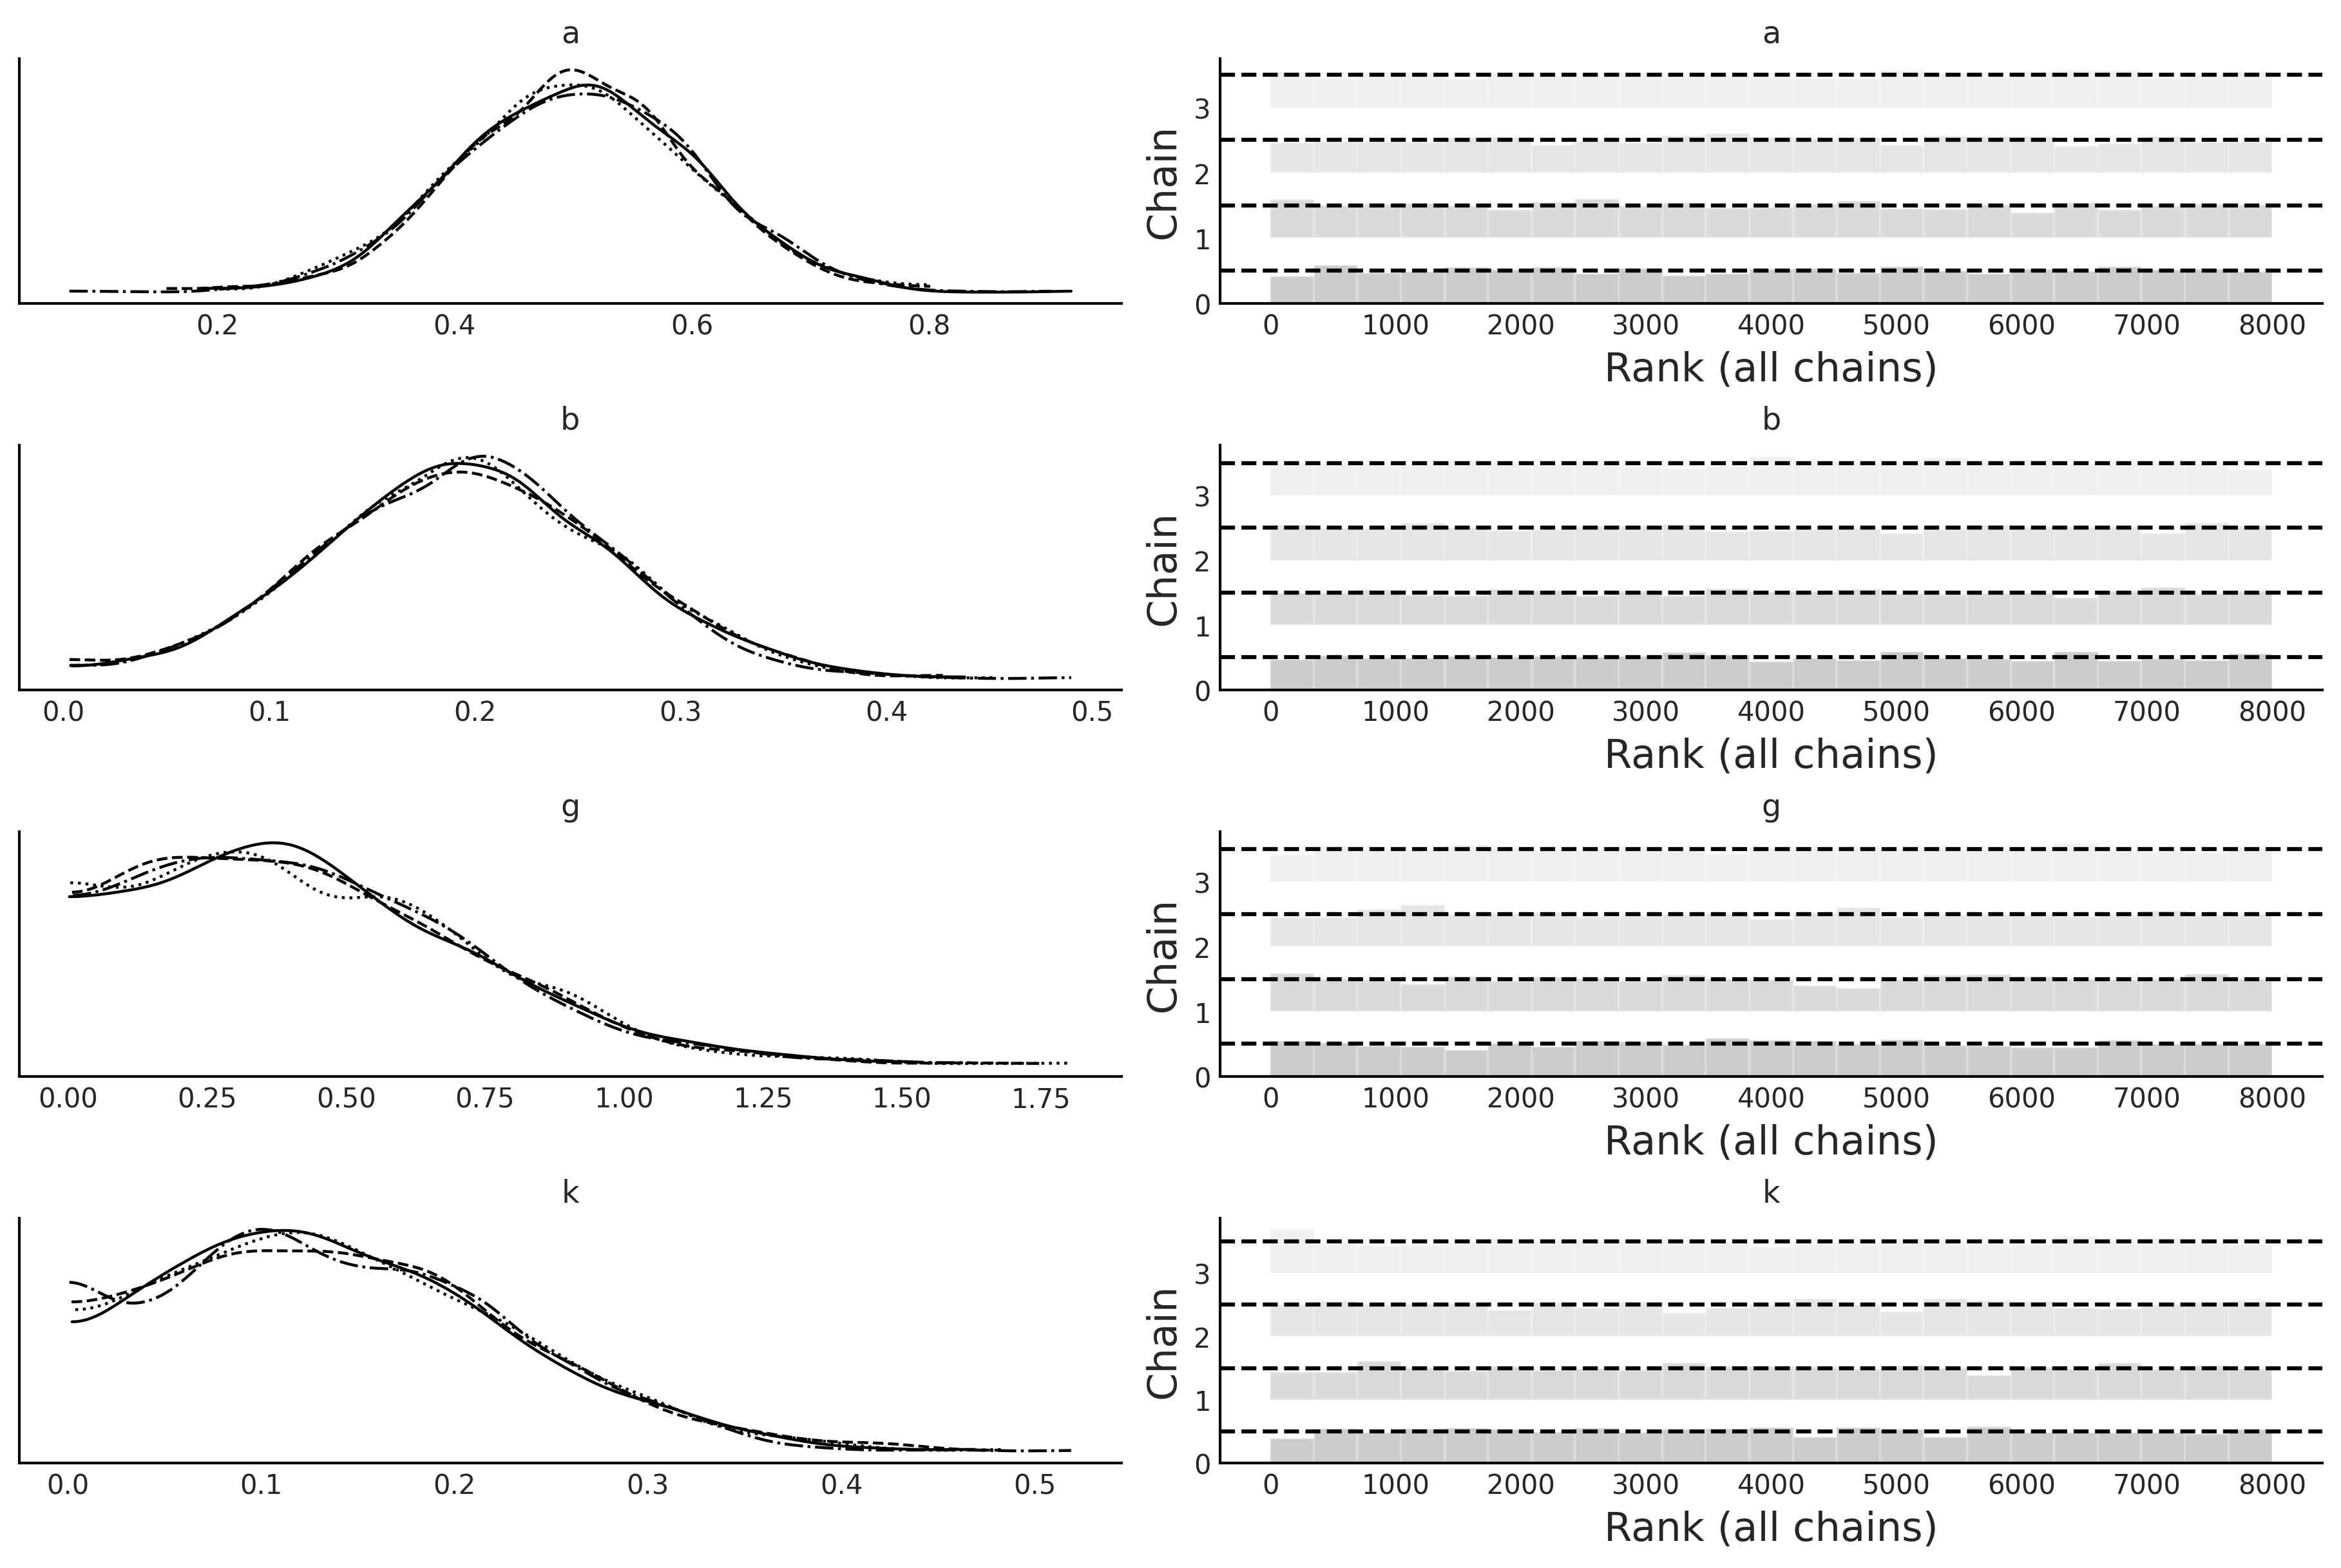

In [22]:
az.plot_trace(idata_gk, kind="rank_bars")
plt.savefig("img/chp08/trace_gk.png")

In [23]:
axes = az.plot_pair(idata_gk, 
                    kind="kde", 
                    marginals=True,
                    textsize=45,
                    kde_kwargs={"contourf_kwargs":{"cmap":plt.cm.viridis}},
                    )

for ax, pad in zip(axes[:,0], (70, 30, 30, 30)):
    ax.set_ylabel(ax.get_ylabel(), rotation=0, labelpad=pad)

plt.savefig("img/chp08/pair_gk.png")

(ABC_MA)=

## 8.6. Approximating Moving Averages

The moving-average (MA) model is a common approach for modeling
univariate time series (see Chapter [6](chap4)). The MA(q) model
specifies that the output variable depends linearly on the current and
$q$ previous past values of a stochastic term $\lambda$. $q$ is known as
the order of the MA model.

```{math}
:label: eq:MA_model
y_t = \mu + \lambda_t + \theta_1 \lambda_{t-1} + \cdots + \theta_q \lambda_{t-q}
```

where $\lambda$ are white Gaussian noise error terms [^9].

We are going to use a toy-model taken from {cite:t}`Marin2012`. For
this example we are going to use the MA(2) model with mean value 0 (i.e.
$\mu =0$), thus our model looks like:

```{math}
:label: eq:MA2_model
y_t = \lambda_t + \theta_1 \lambda_{t-1} +  \theta_2 \lambda_{t-2}
```

Code Block [ma2_simulator_abc](ma2_simulator_abc) shows a
Python simulator for this model and in {numref}`fig:ma2_simulator_abc`
we can see two realizations from that simulator for the values
$\theta1 = 0.6, \theta2=0.2$.


```{code-block} python
:name: ma2_simulator_abc
:caption: ma2_simulator_abc

def moving_average_2(θ1, θ2, n_obs=200):
    λ = np.random.normal(0, 1, n_obs+2)
    y = λ[2:] + θ1*λ[1:-1] + θ2*λ[:-2]
    return y
```

```{figure} figures/ma2_simulator_abc.png
:name: fig:ma2_simulator_abc
:width: 8.00in
Two realizations of a MA(2) model, one with $\theta1=0.6, \theta2 =0.2$.
On the left column the kernel density estimation on the right column the
time series.
```

[^9]: In the literature is common to use $\varepsilon$ to denote these
    terms, but we want to avoid confusion with the $\epsilon$ parameter
    in the SMC-ABC sampler

In [24]:
def moving_average_2(θ1, θ2, n_obs=500):
    λ = np.random.normal(0, 1, n_obs+2)
    y = λ[2:] + θ1*λ[1:-1] + θ2*λ[:-2]
    return y

We are calling the simulator one more time to generate "observed data".

In [25]:
θ1_true = 0.6
θ2_true = 0.2
y_obs = moving_average_2(θ1_true, θ2_true)

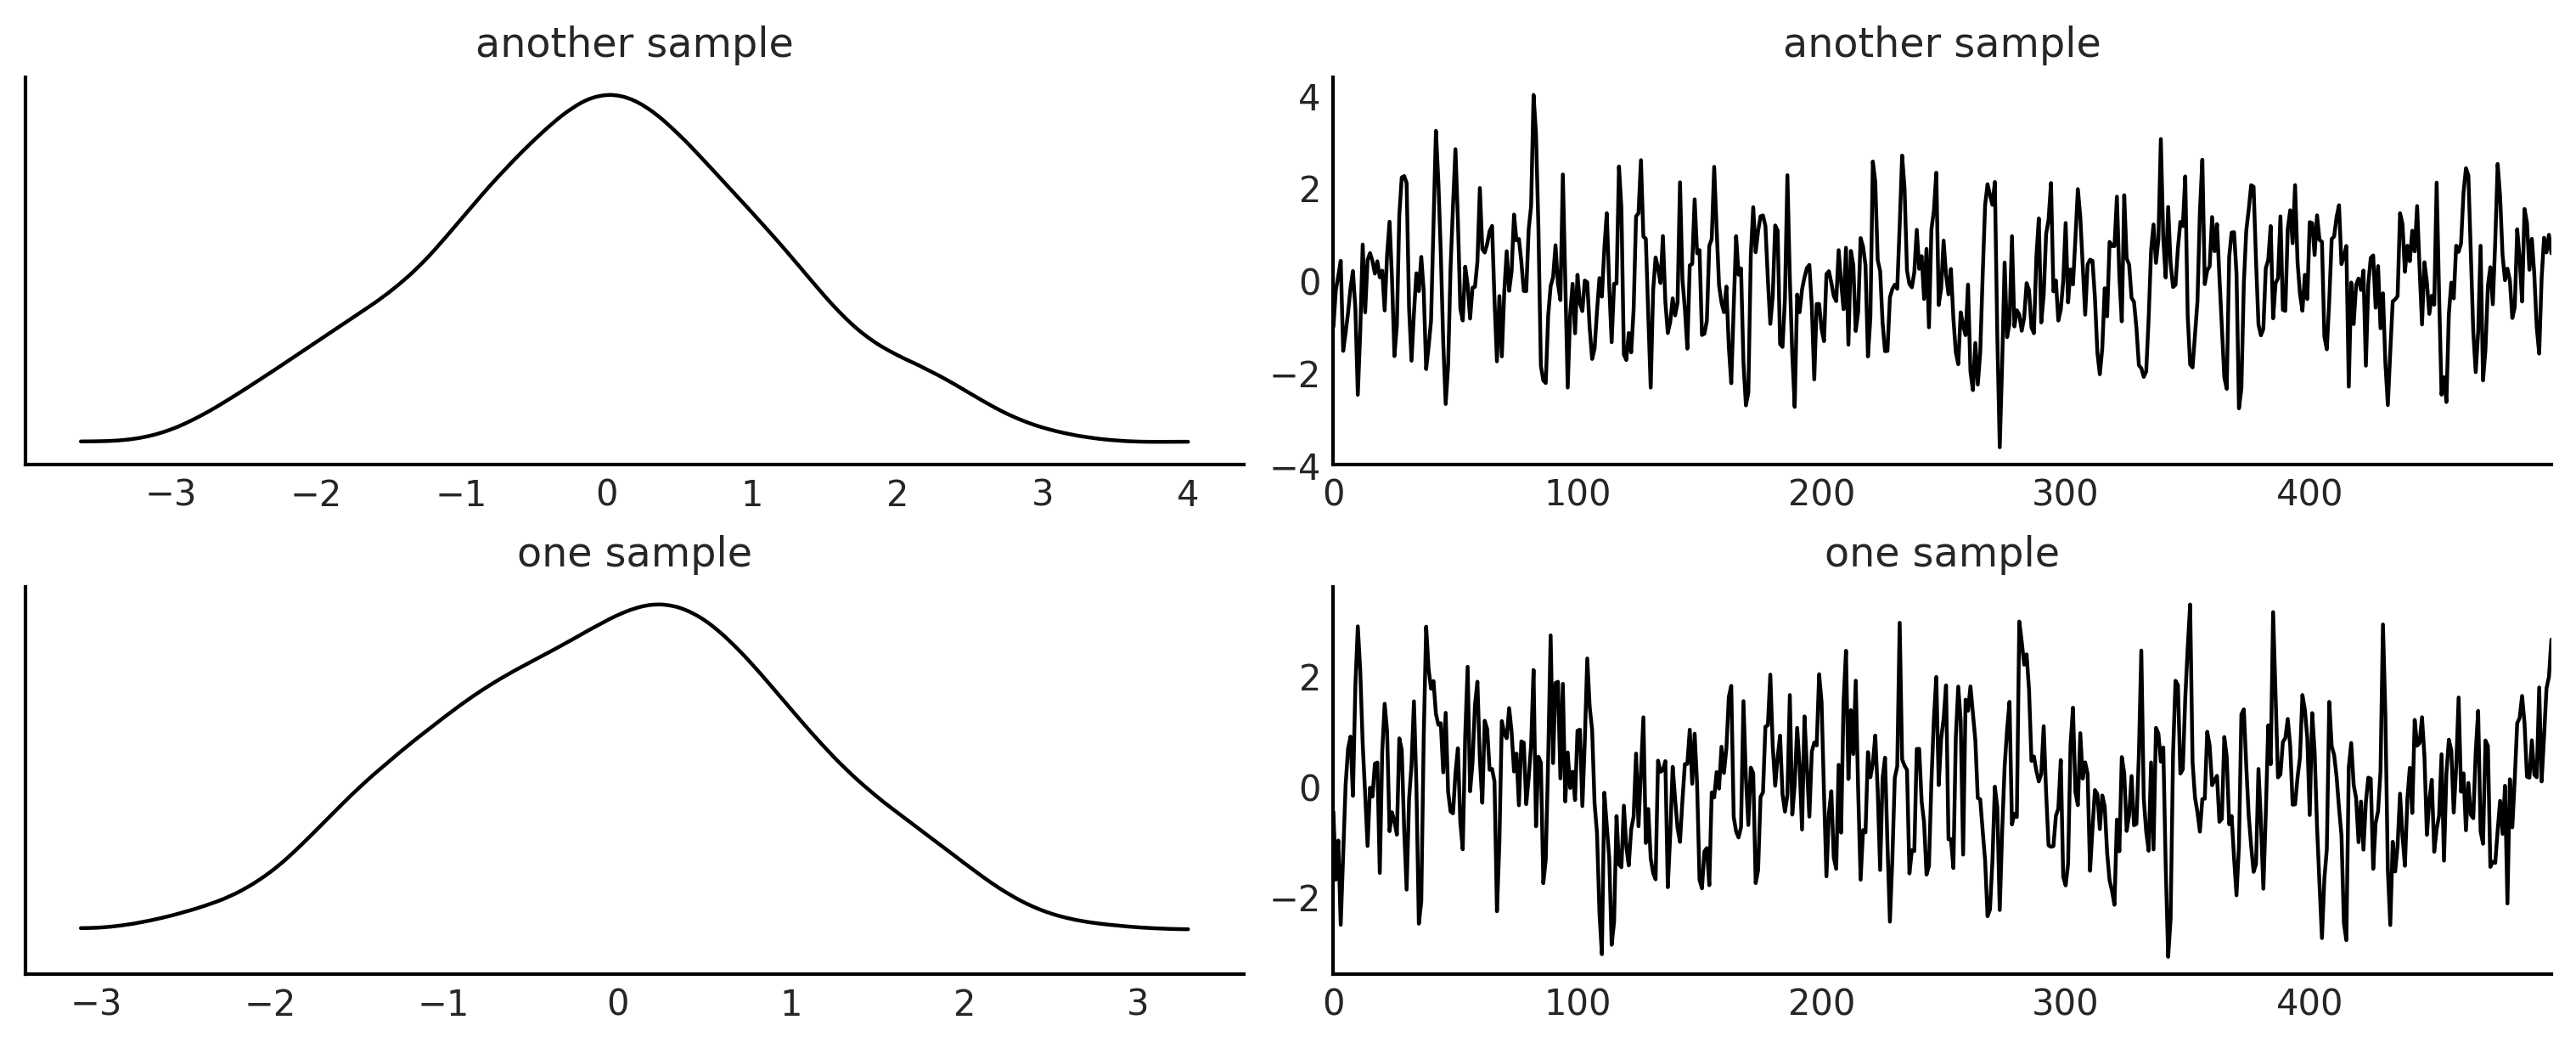

In [26]:
az.plot_trace({'one sample':moving_average_2(θ1_true, θ2_true),
               'another sample':moving_average_2(θ1_true, θ2_true)},
              trace_kwargs={'alpha':1},
              figsize=(10, 4)
             )
plt.savefig("img/chp08/ma2_simulator_abc.png")

In principle we could try to fit a MA(q) model using any distance
function and/or summary statistic we want. Instead, we can use some
properties of the MA(q) model as a guide. One property that is often of
interest in MA(q) models is their autocorrelation. Theory establishes
that for a MA(q) model the lags larger than q will be zero, so for a
MA(2) seems to be reasonable to use as summary statistics the
autocorrelation function for lag 1 and lag 2. Additionally, and just to
avoid computing the variance of the data, we will use the
auto-covariance function instead of the auto-correlation function.

```python
def autocov(x, n=2):
    return np.array([np.mean(x[i:] * x[:-i]) for i in range(1, n+1)])
```

In [27]:
def autocov(x):
    a = np.mean(x[1:] * x[:-1])
    b = np.mean(x[2:] * x[:-2])
    return np.array((a, b))


def moving_average_2(rng, θ1, θ2, size=500):
    λ = rng.normal(0, 1, size[0]+2)
    y = λ[2:] + θ1*λ[1:-1] + θ2*λ[:-2]
    return y

Additionally MA(q) models are non-identifiable unless we introduce a few
restrictions. For a MA(1) model, we need to restrict $-1<\theta_1<1$.
For MA(2) we have $-2<\theta_1<2$, $\theta_1+\theta_2>-1$ and
$\theta_1-\theta_2<1$, this implies that we need to sample from a
triangle as shown in {numref}`fig:ma2_triangle`.

Combining the custom summary statistics and the identifiable
restrictions we have that the ABC model is specified as in Code Block
[MA2_abc](MA2_abc).

```{code-block} python
:name: MA2_abc
:caption: MA2_abc

with pm.Model() as m_ma2:
    θ1 = pm.Uniform("θ1", -2, 2)
    θ2 = pm.Uniform("θ2", -1, 1)
    p1 = pm.Potential("p1", pm.math.switch(θ1+θ2 > -1, 0, -np.inf))
    p2 = pm.Potential("p2", pm.math.switch(θ1-θ2 < 1, 0, -np.inf))

    y = pm.Simulator("y", moving_average_2, 
                     params=[θ1, θ2],
                     sum_stat=autocov,
                     epsilon=0.1,
                     observed=y_obs)

    trace_ma2 = pm.sample_smc(3000, kernel="ABC")
```

A `pm.Potential` is a way to incorporate arbitrary terms to a
(pseudo)-likelihood, without adding new variables to the model. It is
specially useful to introduce restrictions, like in this example. In
Code Block [MA2_abc](MA2_abc) we sum 0 to the likelihood
if the first argument in `pm.math.switch` is true or $-\infty$
otherwise.

```{figure} figures/ma2_trace.png
:name: fig:ma2_trace
:width: 8.00in
ABC trace plot for the MA(2) model. As expected the true parameters are
recovered and the rank plots look satisfactorily flat.
```

```{figure} figures/ma2_triangle.png
:name: fig:ma2_triangle
:width: 8.00in
ABC posterior for the MA(2) model as defined in Code Block
[MA2_abc](MA2_abc). In the center subplot the joint
posterior and in the margins the marginal distributions for $\theta1$
and $\theta2$. The gray triangle represents the prior distribution. The
mean is indicated with a black dot.
```

In [28]:
with pm.Model() as model_ma2:
    θ1 = pm.Uniform('θ1', -2, 2)
    θ2 = pm.Uniform('θ2', -1, 1)
    p1 = pm.Potential("p1", pm.math.switch(θ1+θ2 > -1, 0, -np.inf))
    p2 = pm.Potential("p2", pm.math.switch(θ1-θ2 < 1, 0, -np.inf))

    y = pm.Simulator('y', moving_average_2,
                     params=[θ1, θ2],
                     sum_stat=autocov,
                     epsilon=0.1,
                     observed=y_obs)

    trace_ma2 = pm.sample_smc(3000, chains=4)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [29]:
az.summary(trace_ma2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
θ1  0.666  0.105   0.474    0.869      0.001    0.001   11197.0   10991.0   
θ2  0.396  0.145   0.130    0.676      0.001    0.001   10891.0    9511.0   

    r_hat  
θ1    1.0  
θ2    1.0

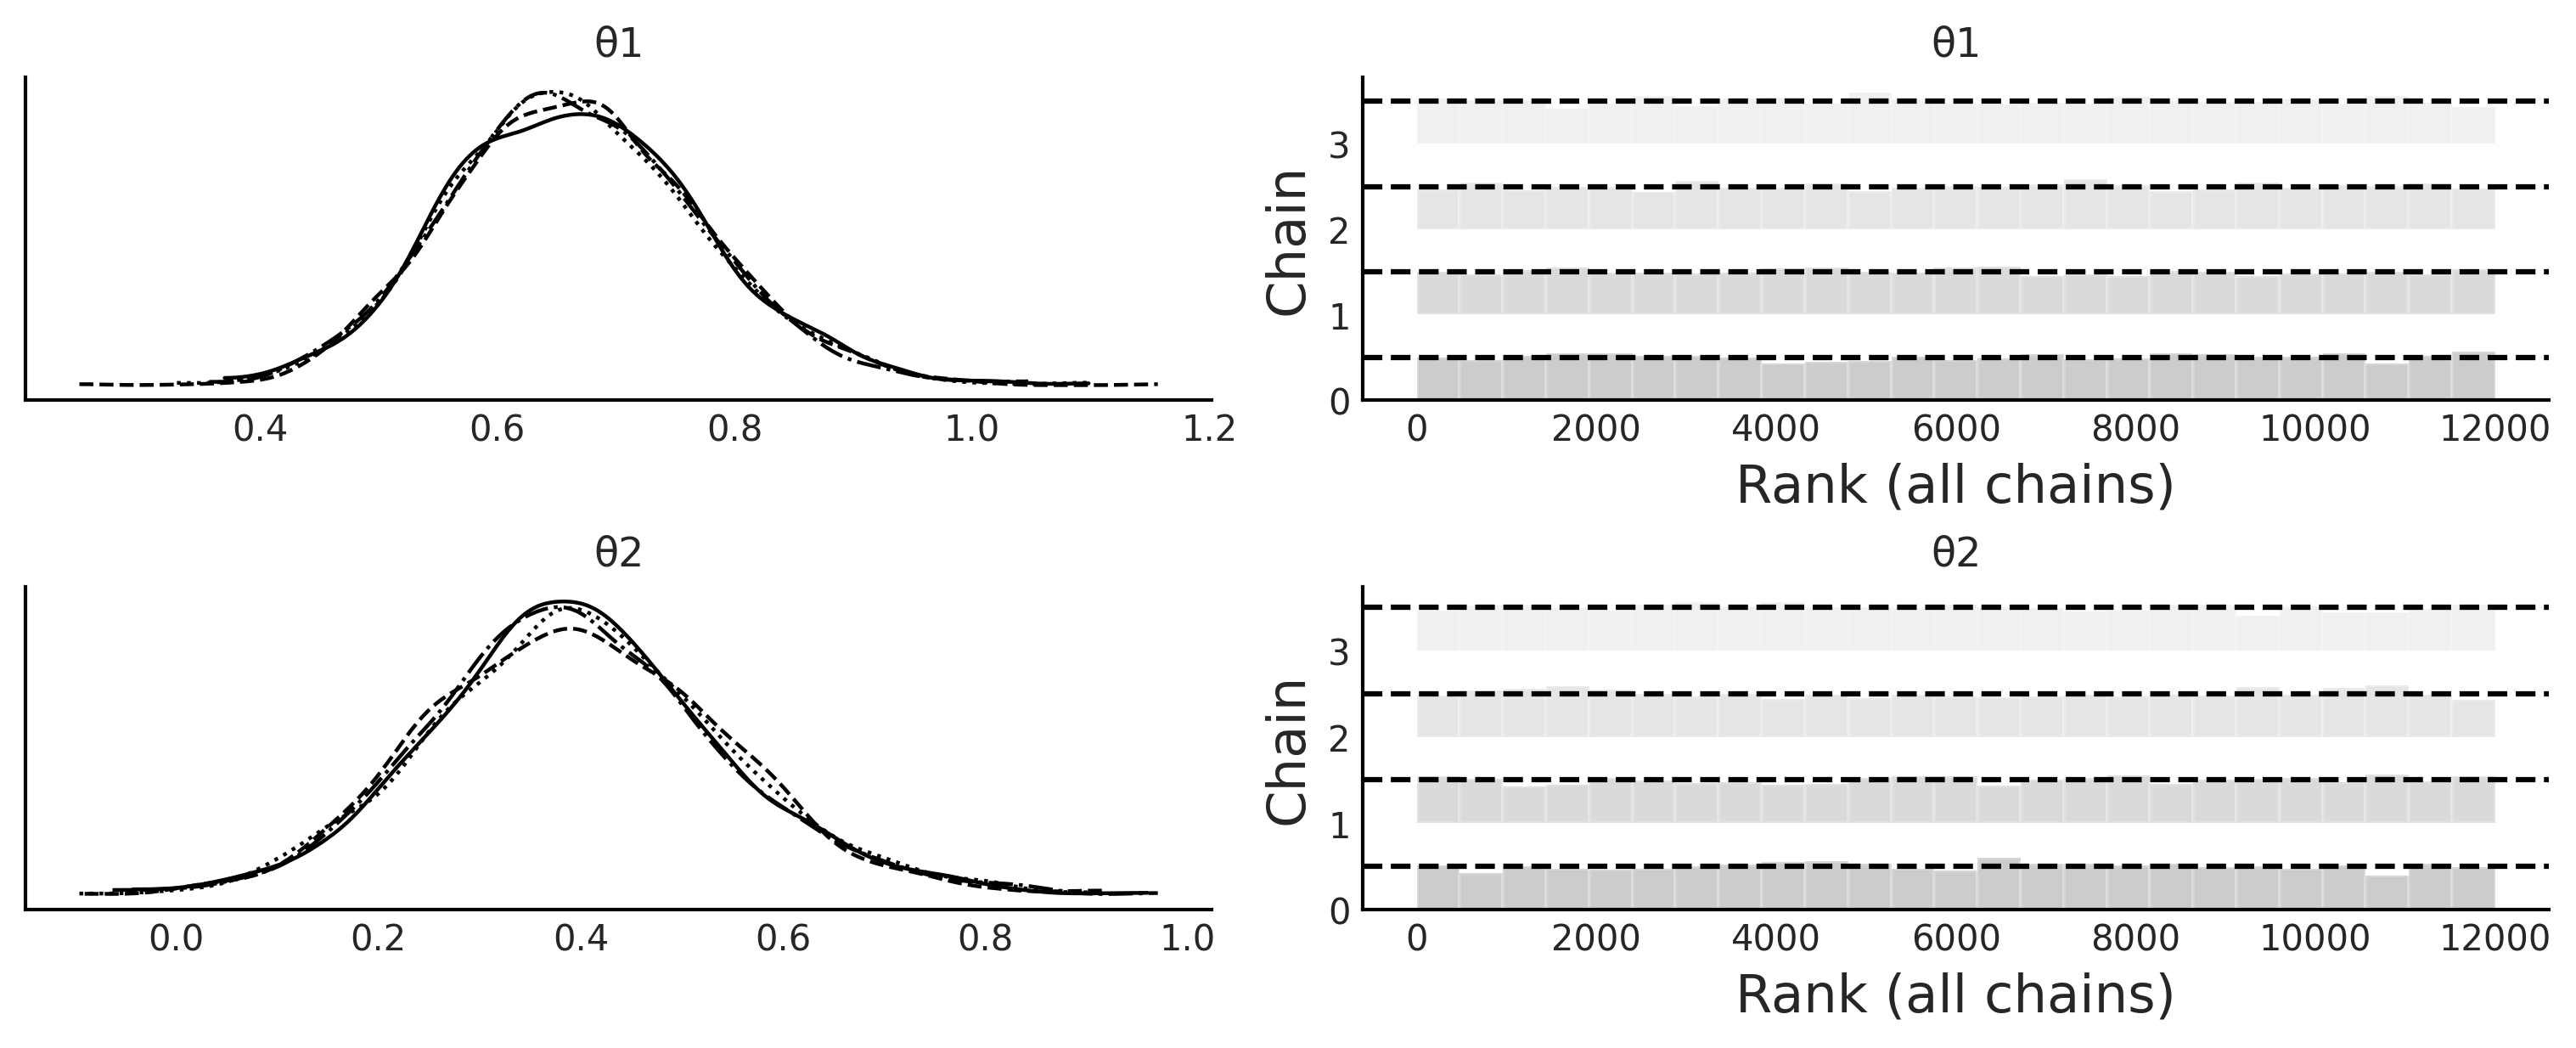

In [30]:
az.plot_trace(trace_ma2, kind="rank_bars", figsize=(10, 4))
plt.savefig("img/chp08/ma2_trace.png")

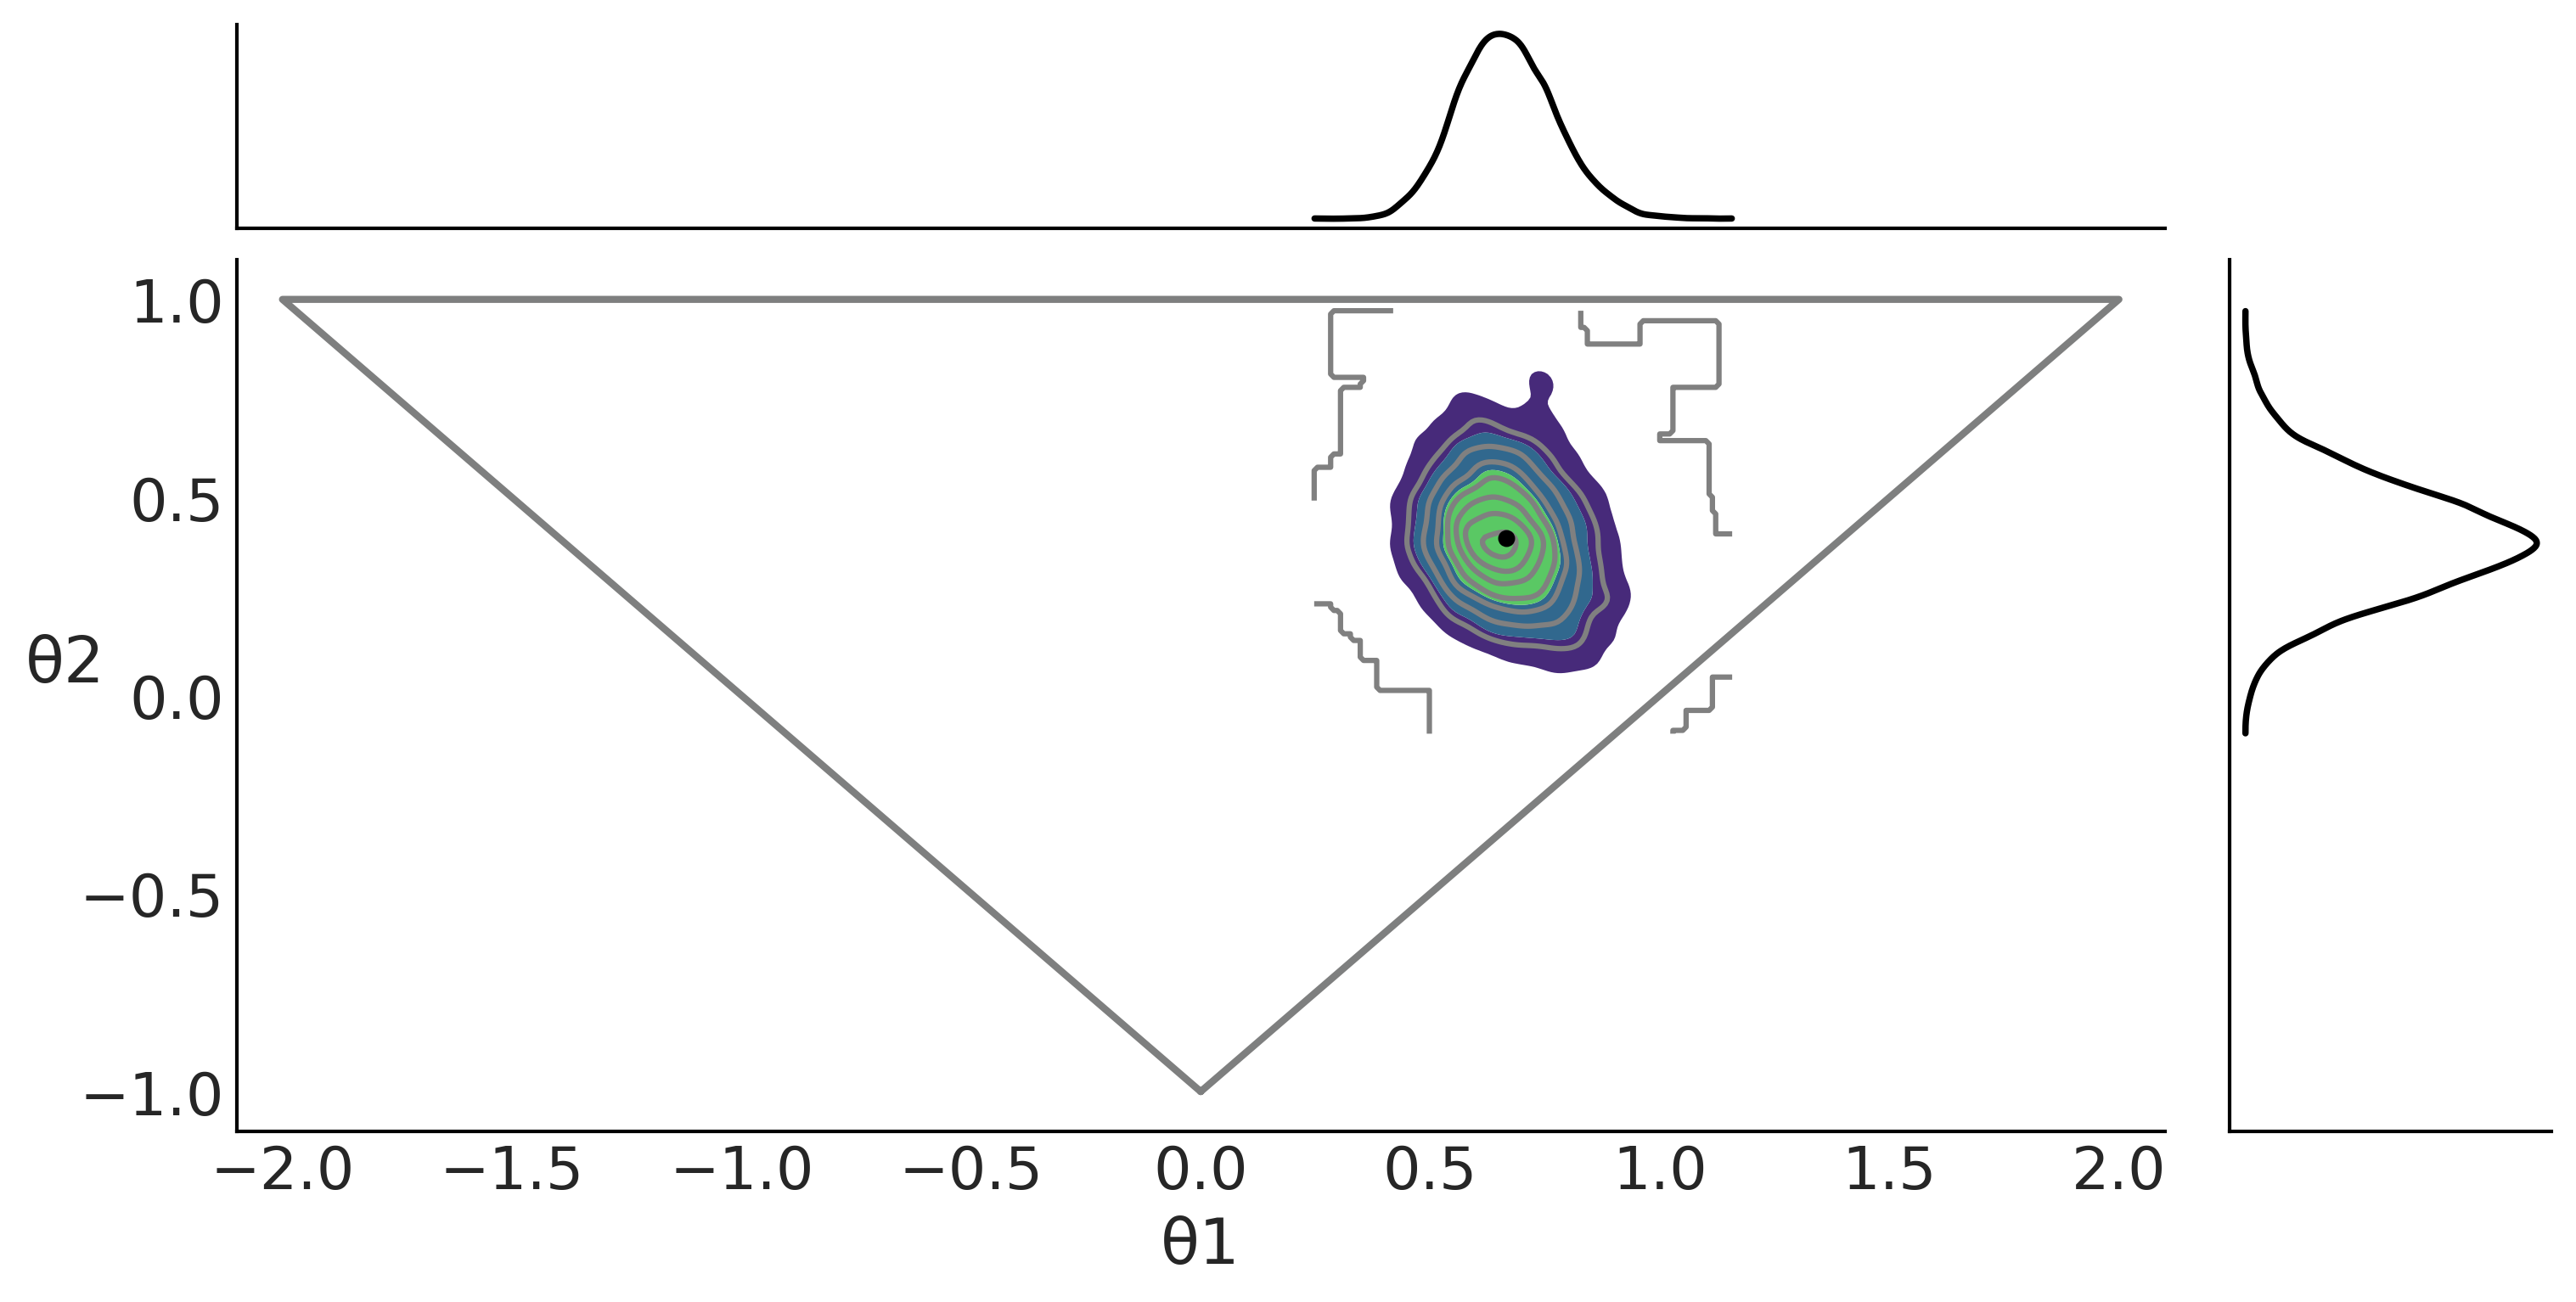

In [31]:
axes = az.plot_pair(trace_ma2, kind="kde", var_names=["θ1", "θ2"],
                    marginals=True, figsize=(10,5),
                    kde_kwargs={"contourf_kwargs":{"cmap":plt.cm.viridis}},
                    point_estimate="mean",
                    point_estimate_kwargs={"ls":"none"},
                    point_estimate_marker_kwargs={"marker":".",
                                                  "facecolor":"k",
                                                  "zorder":2})

axes[1,0].set_xlim(-2.1, 2.1)
axes[1,0].set_ylim(-1.1, 1.1)
axes[1,0].set_ylabel(axes[1,0].get_ylabel(), rotation=0)
axes[1,0].plot([0, 2, -2, 0], [-1, 1, 1, -1], "C2", lw=2)
plt.savefig("img/chp08/ma2_triangle.png")

(model-comparison-in-the-abc-context)=

## 8.7. Model Comparison in the ABC Context

ABC methods are frequently used for model choice. While many methods
have been proposed {cite:p}`Sisson2018, Beaumont2019`, here we will discuss
two approaches; Bayes factors, including a comparison with LOO, and
random forest {cite:p}`Pudlo2015`.

As with parameter inference, the choice of summaries is of crucial
importance for model comparison. If we evaluate two or more models using
their predictions, we can not favour one model over the other if they
all make roughly the same predictions. The same reasoning can be applied
to model choice under ABC with summary statistics. If we use the mean as
the summary statistic, but models predict the same mean, then this
summary statistic will not be sufficient to discriminate between models.
We should take more time to think about what makes models different.

(marginal-likelihood-and-loo)=

### 8.7.1. Marginal Likelihood and LOO

One common quantity used to perform model comparison for ABC methods is
the marginal likelihood. Generally such comparison takes the form of a
ratio of marginal likelihoods, which is known as Bayes factors. If the
value of a Bayes factor is larger than 1, the model in the numerator is
preferred over the one in the denominator and vice versa. In Section {ref}`Bayes_factors` we discuss more details
about Bayes factors, including their caveats. One such caveat is that
the marginal likelihood is generally difficult to compute. Fortunately,
SMC methods and by extension SMC-ABC methods are able to compute the
marginal likelihood as a byproduct of sampling. PyMC3's SMC computes and
saves the log marginal likelihood in the trace. We can access its value
by doing `trace.report.log_marginal_likelihood`. As this value is in a
log scale, to compute a Bayes factor we can do:

```python
ml1 = trace_1.report.log_marginal_likelihood
ml2 = trace_2.report.log_marginal_likelihood
np.exp(ml1 - ml2)
```

When using summary statistics the marginal likelihood computed from ABC
methods cannot be generally trusted to discriminate between competing
models {cite:p}`Robert2011`, unless the summary statistics are sufficient for
model comparison. This is worrisome as, outside a few formal examples or
particular models, there is no general guide to ensure sufficiency
across models {cite:p}`Robert2011`. This is not a problem if we use all the
data i.e. we do not rely on summary statistics [^10]. This resembles our
discussion (see Section {ref}`Bayes_factors`) about how computing
the marginal likelihood is generally a much more difficult problem that
computing the posterior. Even if we manage to find a summary statistic
that is good enough to compute a posterior, that is not a guarantee it
will be also useful for model comparison.

To better understand how the marginal likelihood behaves in the context
of ABC methods we will now analyze a short experiment. We also include
LOO, as we consider LOO an overall better metric than the marginal
likelihood and thus Bayes factors.

The basic setup of our experiment is to compare the values of the log
marginal likelihood and the values computed using LOO for models with an
explicit likelihood against values from ABC models using a simulator
with and without summary statistics. The results are shown in Figures
{numref}`fig:model_comp_normal_0` models in Code Blocks
[gauss_nuts](gauss_nuts) and
[gauss_abc](gauss_abc). The values of the marginal
(pseudo)likelihood are computed as by products of SMC and the values of
LOO using `az.loo()`. Notice that LOO is properly defined on the
pointwise log-likelihood values, but in ABC we only have access to the
pointwise log-*pseudo*likelihood values.

From {numref}`fig:model_comp_normal_0` we can see that in general both
LOO and the log marginal likelihood behave similarly. From the first
column we see that `model_1` is consistently chosen as better than
`model_0` (here higher is better). The difference between models (the
slopes) is larger for the log marginal likelihood than for LOO, this can
be explained as the computation of the marginal likelihood explicitly
takes the prior into account while LOO only does it indirectly through
the posterior (see Section {ref}`Bayes_factors` for details). Even
when the values of LOO and the marginal likelihood vary across samples
they do it in a consistent way. We can see this from the slopes of the
lines connecting `model_0` and `model_1`. While the slopes of the lines
are not exactly the same, they are very similar. This is the ideal
behavior of a model selection method. We can reach similar conclusions
if we compare `model_1` and `model_2`. With the additional consideration
that both models are basically indistinguishable for LOO, while the
marginal likelihood reflects a larger difference. Once again the reason
is that LOO is computed just from the posterior while the marginal
likelihood directly takes the prior into account.

```{figure} figures/model_comp_normal_00.png
:name: fig:model_comp_normal_0
:width: 8.00in
Model `m_0` is similar as the model described in Equation
{eq}`eq:Gauss_model` but with $\sigma \sim \mathcal{HN}(0.1)$. `model_1`
the same as Equation {eq}`eq:Gauss_model`. `model_2` is the same as
Equation {eq}`eq:Gauss_model` but with $\sigma \sim \mathcal{HN}(10)$.
The first row corresponds to values of the log marginal likelihood and
the second row to values computed using LOO. Sequential Monte Carlo
`SMC`, SMC-ABC with the entire dataset `SMC-ABC`, SMC-ABC using the mean
as summary statistic `SMC-ABC_sm` and finally SMC-ABC using the mean and
standard deviation `SMC-ABC_sq`. We run 50 experiments each one with
sample size 50.
```

The second column shows what happens when we move into the ABC realm. We
still get `model_1` as a better choice, but now the dispersion of
`model_0` is much larger than the one from `model_1` or `model_2`.
Additionally we now get lines crossing each other. Taken together, both
observations seems to indicate that we still can use LOO or the log
marginal likelihood to select the best model, but the values of the
relative weights, like the ones computed by `az.compare()` or the Bayes
factors will have larger variability.

The third column shows what happens when we use the mean as summary
statistic. Now model `model_0` and `model_1` seems to be on par and
`model_2` looks like a bad choice. It is almost like the specular image
of the previous column. This shows that when using an ABC method with
summary statistics the log marginal likelihood and LOO can fail to
provide a reasonable answer.

The fourth column shows what happens when we use the standard deviation
in addition to the mean as summary statistic. We see than we can
qualitatively recover the behavior observed when using ABC with the
entire dataset (second column).

::: {admonition}  On the scale of the pseudolikelihood

Notice how the scale on the y-axes
is different, especially across columns. The reason is two-fold, first
when using ABC we are approximating the likelihood with a kernel
function scaled by $\epsilon$, second when using a summary statistic we
are decreasing the size of the data. Notice also that this size will
keep constant if we increase the sample size for summary statistics like
the mean or quantiles, i.e. the mean is a single number irrespective if
we compute it from 10 or 1000 observations.
:::

{numref}`fig:model_comp_normal_forest` can help us to understand what we
just discussed from {numref}`fig:model_comp_normal_0`. We recommend you
analyze both figures together by yourself. For the moment we will focus
on two observations. First, when performing `SMC-ABC_sm` we have a
sufficient statistics for the mean but nothing to say about the
dispersion of the data, thus the posterior uncertainty of both
parameters `a` and `σ` is essentially controlled by the prior. See how
the estimates from `model_0` and `model_1` are very similar for `μ` and
the uncertainty from `model_2` is ridiculously large. Second, and
regarding the parameter `σ` the uncertainty is very small for `model_0`,
wider that it should be for `model_1` and ridiculously large for
`model_2`. Taken all together we can see why the log marginal likelihood
and LOO indicate that `model_0` and `model_1` are on par but `model_2`
is very different. Basically, `SMC-ABC_sm` is failing to provide a good
fit! Once we see this is no longer surprising that the log marginal
likelihood and LOO computed from `SMC-ABC_sm` contradicts what is
observed when we use `SMC` or `SMC-ABC`. If we use the mean and the
standard deviation `SMC-ABC_sq` as summary statistics we partially
recover the behavior of using the whole data-set `SMC-ABC`.

```{figure} figures/model_comp_normal_forest.png
:name: fig:model_comp_normal_forest
:width: 8.00in
Model `m_0` is similar as the model described in Equation
{eq}`eq:Gauss_model` but with $\sigma \sim \mathcal{HN}(0.1)$. `model_1`
the same as Equation {eq}`eq:Gauss_model`. `model_2` is the same as
Equation {eq}`eq:Gauss_model` but with $\sigma \sim \mathcal{HN}(10)$.
The first row contains the values of the marginal likelihood and the
second the values of LOO. The column represents different methods of
computing these values. Sequential Monte Carlo `SMC`, SMC-ABC with the
entire dataset `SMC-ABC`, SMC-ABC using the mean as summary statistic
`SMC-ABC_sm` and finally SMC-ABC using the mean and standard deviation
`SMC-ABC_sq`. We run 50 experiments each one with sample size 50.
```

Figures {numref}`fig:model_comp_pois_geom_0` and
{numref}`fig:model_comp_pois_geom_forest` shows a similar analysis but
`model_0` is a geometric model and `model_1` is a Poisson model. The
data follows a shifted Poisson distribution
$\mu \sim 1 + \text{Pois}(2.5)$. We leave the analysis of these figures
as an exercise for the readers.

```{figure} figures/model_comp_pois_geom_00.png
:name: fig:model_comp_pois_geom_0
:width: 8.00in
Model `m_0` is a geometric distribution with prior
$p \sim \mathcal{U}(0, 1)$ and `model_1` is a Poisson distribution with
prior $\mu \sim \mathcal{E}(1)$. The data follows a shifted Poisson
distribution $\mu \sim 1 + \text{Pois}(2.5)$. Sequential Monte Carlo
`SMC`, SMC-ABC with the entire dataset `SMC-ABC`, SMC-ABC using the mean
as summary statistic `SMC-ABC_sm` and finally SMC-ABC using the mean and
standard deviation `SMC-ABC_sq`.We run 50 experiments each one with
sample size 50.
```

```{figure} figures/model_comp_pois_geom_forest.png
:name: fig:model_comp_pois_geom_forest
:width: 8.00in
`model_0` a geometric model/simulator with prior
$p \sim \mathcal{U}(0, 1)$ `model_1` A Poisson model/simulator with
prior $p \sim \text{Expo}(1)$. The firs row contains the values of the
marginal likelihood and the second the values of LOO. The column
represents different methods of computing these values. Sequential Monte
Carlo `SMC`, SMC-ABC with the entire dataset `SMC-ABC`, SMC-ABC using
the mean as summary statistic `SMC-ABC_sq` and finally SMC-ABC using
quartiles `SMC-ABC_sq`. We run 50 experiments each one with sample size
50.
```

In the ABC literature it is common to use Bayes factors in an attempt to
assign relative probabilities to models. We understand this can be
perceived as valuable in certain fields. So we want to warn those
practitioners about the potential problems of this practice under the
ABC framework, especially because it is much more common to use summary
statistics than not. Model comparison can still be useful, mainly if a
more exploratory approach is adopted together with model criticism
performed before model comparison to improve or discard clearly
misspecified models. This is the general approach we have adopted in
this book for non-ABC methods so we consider natural to extend it into
the ABC framework as well. In this book we also favor LOO over the
marginal likelihood, while research about the benefits and drawbacks of
LOO for ABC methods are currently lacking, we consider LOO to be
potentially useful for ABC methods too. Stay tuned for future news!

::: {admonition}  Model criticism and model comparison

While some amount of misspecification is always expected, and model comparison can help to
better understand models and their misspecification. Model comparison
should be done only after we have shown the models provide a reasonable
fit to the data. It does not make too much sense to compare models that
are clearly a bad fit.
:::

[^10]: Good moment to remember that `sum_stat="sort"` is not actually a
    summary statistic as we are using the entire dataset

(model-choice-via-random-forest)=

### 8.7.2. Model Choice via Random Forest

The caveats we discussed in the previous section has motivated the
research of new methods for model choice under the ABC framework. One
such alternative method reframes the model selection problem as random
forest classification problem {cite:p}`Pudlo2015` [^11]. A random forest is a
method for classification and regression based on the combination of
many decision trees and it is closely related to BARTs from Chapter
[7](chap6).

The main idea of this method is that the most probable model can be
obtained by constructing a random forest classifier from simulations
from the prior or posterior predictive distributions. In the original
paper authors use the prior predictive distribution but mention that for
more advanced ABC method other distributions can be used too. Here we
will use the posterior predictive distribution. For each model up to $m$ models, the simulations are
ordered in a reference table (see {numref}`table:ABC_random_forest_ref_table`).
where each row is a sample
from the posterior predictive distribution and each column is one out of
$n$ summary statistics. We use this reference table to train the
classifier, the task is to correctly classify the models given the
values of the summary statistics. It is important to note that the
summary statistics used for model choice does not need to be the same
used to compute the posterior. In fact it is recommended to include many
summary statistics. Once the classifier is trained we feed it with the
same $n$ summary statistics we used in the reference table, but this
time applied to our observed data. The predicted model by the classifier
will be our best model.


```{list-table} Reference table
:name: table:ABC_random_forest_ref_table

* - **Model**
  - $\mathbf{S^{0}}$
  - $\mathbf{S^{1}}$
  - ...
  - $\mathbf{S^{n}}$
* - 0
  -
  -
  - ...
  -
* - 0
  -
  -
  - ...
  -
* - ...
  - ...
  - ...
  - ...
  - ...
* - 1
  -
  -
  - ...
  -
* - 1
  -
  -
  - ...
  -
* - m
  -
  -
  - ...
  -
```

Additionally, we can also compute an approximated posterior probability
for the *best* model, relative to the rest of the models. Once again,
this can be done using a random forest, but this time we use a
regression, with the misclassification error rate as response variable
and the summary statistics in the reference table as independent
variables {cite:p}`Pudlo2015`.

[^11]: Other classifiers could have been chosen, but the authors decided
    to use a random forest.

(model-choice-for-ma-model)=

### 8.7.3. Model Choice for MA Model

Let us go back to the moving average example, this time we will focus on
the following question. Is a MA(1) or MA(2) a better choice? To answer
this question we will use LOO (based on the pointwise pseudo-likelihood
values) and random forest. The MA(1) models looks like this


```{code-block} python
:name: MA1_abc
:caption: MA1_abc

with pm.Model() as m_ma1:
    θ1 = pm.Uniform("θ1", -1, 1)
    y = pm.Simulator("y", moving_average_1,
                     params=[θ1], sum_stat=autocov, epsilon=0.1, observed=y_obs)
    trace_ma1 = pm.sample_smc(2000, kernel="ABC")
```

In order to compare ABC-models using LOO. We cannot directly use the
function `az.compare`. We first to need to create an `InferenceData`
object with a `log_likelihood` group as detailed in Code Block
[idata_pseudo](idata_pseudo) [^12]. The result of this
comparison is summarized in {numref}`table:abc_loo`. As
expected, we can see that the MA(2) model is preferred.

```{code-block} python
:name: idata_pseudo
:caption: idata_pseudo

idata_ma1 = az.from_pymc3(trace_ma1)
lpll = {"s": trace_ma2.report.log_pseudolikelihood}
idata_ma1.log_likelihood = az.data.base.dict_to_dataset(lpll)

idata_ma2 = az.from_pymc3(trace_ma2)
lpll = {"s": trace_ma2.report.log_pseudolikelihood}
idata_ma2.log_likelihood = az.data.base.dict_to_dataset(lpll)

az.compare({"m_ma1":idata_ma1, "m_ma2":idata_ma2})
```


```{list-table} Summary ABC-model comparison using LOO
:name: table:abc_loo
* -
  - **rank**
  - **loo**
  - **p_loo**
  - **d_loo**
  - **weight**
  - **se**
  - **dse**
  - **warning**
  - **loo_scale**
* -  model_ma2
  -    0
  -  -2.22
  -   1.52
  -   0.00
  -   1.0
  -   0.08
  -   0.00
  - False
  - log
* -  model_ma1
  -    1
  -  -3.53
  -   2.04
  -   1.31
  -   0.0
  -   1.50
  -   1.43
  - False
  - log
```

[^12]: In future versions of PyMC `pm.sample_smc` will return and
    InferenceData object with the proper groups.

In [32]:
def moving_average_1(rng, θ1, size=(500,)):
    λ = rng.normal(0, 1, size[0]+1)
    y = λ[2:] + θ1*λ[1:-1]
    return y

def moving_average_2(rng, θ1, θ2, size=(500,)):
    λ = rng.normal(0, 1, size[0]+2)
    y = λ[2:] + θ1*λ[1:-1] + θ2*λ[1:-1]
    return y

rng = np.random.default_rng(1346)
θ1_true = 0.7
θ2_true = 0.3
y_obs = moving_average_2(rng, θ1_true, θ2_true)

In [33]:
def autocov(x, n=2):
    return np.array([np.mean(x[i:] * x[:-i]) for i in range(1, n+1)])

In [34]:
with pm.Model() as model_ma1:
    θ1 = pm.Uniform('θ1', -2, 2)
    y = pm.Simulator('y', moving_average_1,
                     params=[θ1], sum_stat=autocov, epsilon=0.2, observed=y_obs)
    idata_ma1 = pm.sample_smc(3000, chains=4, idata_kwargs={"log_likelihood":True})

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [35]:
with pm.Model() as model_ma2:
    θ1 = pm.Uniform('θ1', -2, 2)
    θ2 = pm.Uniform('θ2', -1, 1)
    p1 = pm.Potential("p1", pm.math.switch(θ1+θ2 > -1, 0, -np.inf))
    p2 = pm.Potential("p2", pm.math.switch(θ1-θ2 < 1, 0, -np.inf))

    y = pm.Simulator('y', moving_average_2,
                     params=[θ1, θ2],
                     sum_stat=autocov,
                     epsilon=0.1,
                     observed=y_obs)

    idata_ma2 = pm.sample_smc(3000, chains=4, idata_kwargs={"log_likelihood":True})

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [36]:
mll_ma2 = np.nanmean(np.concatenate([np.hstack(v) for v in idata_ma2.sample_stats.log_marginal_likelihood.values]))
mll_ma1 = np.nanmean(np.concatenate([np.hstack(v) for v in idata_ma1.sample_stats.log_marginal_likelihood.values]))

mll_ma2/mll_ma1

1.853203119708982

In [37]:
cmp = az.compare({"model_ma1":idata_ma1, "model_ma2":idata_ma2})
cmp

/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/arviz/stats/stats.py:1043: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/hwting/anaconda3/envs/rapids-24.12/lib/python3.11/site-packages/arviz/stats/stats.py:795: U

rank   elpd_loo      p_loo  elpd_diff        weight         se  \
model_ma1     0 -13.014108  11.884014   0.000000  1.000000e+00   6.734947   
model_ma2     1 -61.828554  59.554241  48.814446  8.881784e-16  12.654715   

                dse  warning scale  
model_ma1  0.000000     True   log  
model_ma2  5.919768     True   log

To use the random forest method we can use the `select_model` function
included in the accompanying code for this book. To make this function
work we need to pass a list of tuples with the PyMC3's model names and
traces, a list of summary statistics, and the observed data. Here as
summary statistics we will use the first six auto-correlations. We
choose these particular summary statistics for two reasons, first to
show that we can use a set of summary statistics different from the one
used to fit the data and second two show that we can mix useful summary
statistics (the first two auto-correlations), with not very useful ones
(the rest). Remember that theory says that for a MA(q) processes there
are at most q auto-correlations. For complex problems, like those from
population genetics it is not uncommon to use several hundreds or even
tens of thousands of summary statistics {cite:p}`Collin2020`.

```python
from functools import partial
select_model([(m_ma1, trace_ma1), (m_ma2, trace_ma2)],
             statistics=[partial(autocov, n=6)],
             n_samples=5000,
             observations=y_obs)
```

`select_model` returns the index of the best model (starting from 0) and
the estimated posterior probability for that model. For our example we
get model 0 with a probability of 0.68. It is a little bit reassuring
that, at least for this example, both LOO and the random forest method
agree on model choice and even their relative weight.

In [38]:
# from functools import partial
# select_model([(model_ma1, idata_ma1), (model_ma2, idata_ma2)], 
#              statistics=[partial(autocov, n=6)],
#              n_samples=10000,
#              observations=y_obs)

(choosing-priors-for-abc)=

## 8.8. Choosing Priors for ABC

Not having a closed form likelihood makes it more difficult to get good
models and thus ABC methods are in general more brittle than other
approximations. Consequently we should be extra careful about modeling
choices, including prior elicitation, and more thorough about model
evaluation than when we have an explicit likelihood. These are the costs
we pay for approximating the likelihood.

A more careful prior elicitation can be much more rewarding with ABC
methods than with other approaches. If we lose information by
approximating the likelihood we can maybe partially compensate that loss
by using a more informative prior. Additionally, better priors will
generally save us from wasting computational resources and time. For ABC
rejection methods, where we use the prior as the sampling distribution,
this is more or less evident. But it is also the case for SMC methods,
specifically if the simulator are sensitive to the input parameter. For
example, when using ABC to inference a ordinary differential equation,
some parameter combination could be numerical challenging to simulate,
resulting in extremely slow simulation. Another problem of using vague
prior arise during the weighted sampling in SMC and SMC-ABC, as almost
all but few samples from the prior would have extremely small weights
when evaluated on the tempered posteriors. This leads to the SMC
particles to become singular after just a few steps (as only few samples
with large weight are selected). This phenomenon is called weight
collapse, a well known issue for particle methods {cite:p}`bickel2008sharp`.
Good priors can help to reduce the computational cost and thus to some
extent allow us to fit more complex models when we are using SMC and
SMC-ABC. Beyond the general advice of more informative prior and what we
have already discussed elsewhere in the book about prior
elicitation/evaluation, we do not have further recommendation specific
for ABC methods.

(exercises8)=

## 8.9. Exercises

**8E1.** In your words explain how ABC is approximate? What
object or quantity is approximated and how.

**8E2.** In the context of ABC, what is the problem that SMC
is trying to solve compared to rejection sampling?

**8E3.** Write a Python function to compute the Gaussian
kernel as in Equation {eq}`eq:euclidean_abc`, but without the summation.
Generate two random samples of size 100 from the same distribution. Use
the implemented function to compute the distances between those two
random samples. You will get two distributions each of size 100. Show
the differences using a KDE plot, the mean and the standard deviation.

**8E4.** What do you expect to the results to be in terms of
accuracy and convergence of the sampler if in model `gauss` model from
Code Block [gauss_abc](gauss_abc) we would have used
`sum_stat="identity"`. Justify.

**8E5.** Refit the `gauss` model from Code Block
[gauss_abc](gauss_abc) using `sum_stat="identity"`.
Evaluate the results using:

1.  Trace Plot

2.  Rank Plot

3.  $\hat R$

4.  The mean and HDI for the parameters $\mu$ and $\sigma$.

Compare the results with those from the example in the book (i.e. using
`sum_stat="sort"`).

**8E6.** Refit the `gauss` model from Code Block
[gauss_abc](gauss_abc) using quintiles as summary
statistics.

1.  How the results compare with the example in the book?

2.  Try other values for `epsilon`. Is 1 a good choice?

**8E7.** Use the `g_and_k_quantile` class to generate a
sample (n=500) from a g-and-k distribution with parameters
a=0,b=1,g=0.4,k=0. Then use the `gkm` model to fit it using 3 different
values of $\epsilon$ (0.05, 0.1, 0.5). Which value of $\epsilon$ do you
think is the best for this problem? Use diagnostics tools to help you
answer this question.

**8E8.** Use the sample from the previous exercise and the
`gkm` model. Fit the using the summary statistics `octo_summary`, the
`octile-vector` (i.e. the quantiles 0.125, 0.25, 0.375, 0.5, 0.625,
0.75, 0.875) and `sum_stat="sorted"`. Compare the results with the known
parameter values, which option provides higher accuracy and lower
uncertainty?

**8M9.** In the GitHub repository you will find a dataset of
the distribution of citations of scientific papers. Use SMC-ABC to fit a
g-and-k distribution to this dataset. Perform all the necessary steps to
find a suitable value for `"epsilon"` and ensuring the model converge
and results provides a suitable fit.

**8M10.** The Lotka-Volterra is well-know biological model
describing how the number of individuals of two species change when
there is a predator-prey interaction {cite:p}`Otto2007`. Basically, as the
population of prey increase there is more food for the predator which
leads to an increase in the predator population. But a large number of
predators produce a decline in the number of pray which in turn produce
a decline in the predator as food becomes scarce. Under certain
conditions this leads to an stable cyclic pattern for both populations.
In the GitHub repository you will find a Lotka-Volterra simulator with
unknown parameters and the data set `Lotka-Volterra_00`. Assume the
unknown parameters are positive. Use a SMC-ABC model to find the
posterior distribution of the parameters.

**8H11.** Following with the Lotka-Volterra example. The
dataset `Lotka-Volterra_01` includes data for a predator prey with the
twist that at some point a disease suddenly decimate the prey
population. Expand the model to allow for a "switchpoint", i.e. a point
that marks two different predator-prey dynamics (and hence two different
set of parameters).

**8H12.** This exercise is based in the sock problem
formulated by Rasmus Bååth. The problem goes like this. We get 11 socks
out of the laundry and to our surprise we find that they are all unique,
that is we can not pair them. What is the total number of socks that we
laundry? Let assume that the laundry contains both paired and unpaired
socks, we do not have more than two socks of the same kind. That is we
either have 1 or 2 socks of each kind.

Assume the number of socks follows a $\text{NB}(30, 4.5)$. And that the
proportion of unpaired socks follows a $\text{Beta}(15, 2)$

Generate a simulator suitable for this problem and create a SMC-ABC
model to compute the posterior distribution of the number of socks, the
proportion of unpaired socks, and the number of pairs.